## CUPED (Controlled-experiemnt Using Pre-Experiemnt Data)
> CUPED is a variance decurtion technique used in A/B testing that leverages pre-experiment data to reduce noise and increase the sensitivity of the experiments.

### ALL-IN-ONE

CUPED A/B TEST ANALYSIS

--- ORIGINAL ANALYSIS (No CUPED) ---
Control Mean:     170.31
Treatment Mean:   172.88
Effect:           2.57
Standard Error:   0.671
T-statistic:      3.837
P-value:          0.0001
95% CI:           [1.26, 3.89]

--- CUPED ANALYSIS ---
Control Mean:     170.66
Treatment Mean:   172.52
Effect:           1.86
Standard Error:   0.270
T-statistic:      6.883
P-value:          0.0000
95% CI:           [1.33, 2.39]

Theta:            0.6959
Variance Reduction: 83.8%

--- IMPROVEMENTS ---
Standard Error Reduction: 59.8%
Confidence Interval Width Reduction: 59.8%


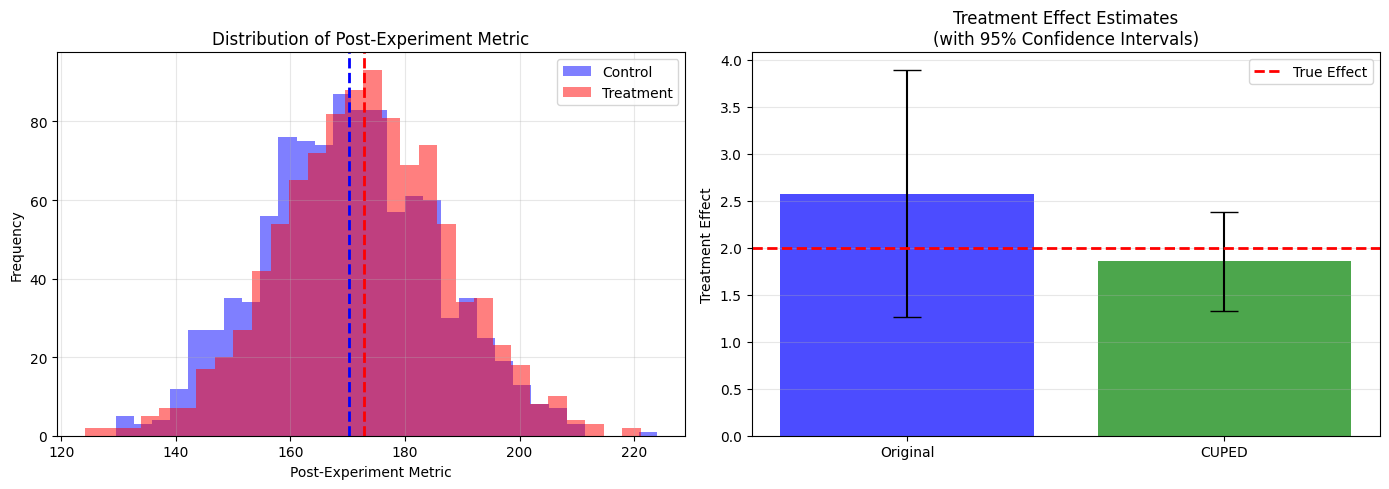


Analysis complete! CUPED successfully reduced variance.


In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

class CUPED:
    """
    CUPED (Controlled-experiment Using Pre-Experiment Data)
    Variance reduction technique for A/B testing
    """

    def __init__(self):
        self.theta = None
        self.X_mean = None

    def fit(self, Y, X):
        """
        Calculate optimal theta coefficient

        Parameters:
        -----------
        Y : array-like
            Post-experiment metric
        X : array-like
            Pre-experiment covariate
        """
        # Calculate covariance and variance
        cov_YX = np.cov(Y, X)[0, 1]
        var_X = np.var(X, ddof=1)

        # Optimal theta = Cov(Y,X) / Var(X)
        self.theta = cov_YX / var_X
        self.X_mean = np.mean(X)

        return self

    def transform(self, Y, X):
        """
        Apply CUPED adjustment

        Parameters:
        -----------
        Y : array-like
            Post-experiment metric
        X : array-like
            Pre-experiment covariate

        Returns:
        --------
        Y_adj : array
            Adjusted metric
        """
        if self.theta is None:
            raise ValueError("Must call fit() before transform()")

        # Y_adj = Y - theta * (X - E[X])
        Y_adj = Y - self.theta * (X - self.X_mean)

        return Y_adj

    def fit_transform(self, Y, X):
        """Fit and transform in one step"""
        self.fit(Y, X)
        return self.transform(Y, X)


def analyze_experiment(control_metric, treatment_metric,
                       control_covariate, treatment_covariate,
                       use_cuped=True):
    """
    Analyze A/B test results with and without CUPED

    Parameters:
    -----------
    control_metric : array-like
        Post-experiment metric for control group
    treatment_metric : array-like
        Post-experiment metric for treatment group
    control_covariate : array-like
        Pre-experiment covariate for control group
    treatment_covariate : array-like
        Pre-experiment covariate for treatment group
    use_cuped : bool
        Whether to apply CUPED adjustment
    """

    # Combine data for calculating theta
    Y_all = np.concatenate([control_metric, treatment_metric])
    X_all = np.concatenate([control_covariate, treatment_covariate])

    results = {}

    # --- Original Analysis ---
    mean_control_orig = np.mean(control_metric)
    mean_treatment_orig = np.mean(treatment_metric)

    # Calculate pooled standard error
    var_control_orig = np.var(control_metric, ddof=1)
    var_treatment_orig = np.var(treatment_metric, ddof=1)
    n_control = len(control_metric)
    n_treatment = len(treatment_metric)

    se_orig = np.sqrt(var_control_orig/n_control + var_treatment_orig/n_treatment)

    # Treatment effect and t-test
    effect_orig = mean_treatment_orig - mean_control_orig
    t_stat_orig = effect_orig / se_orig
    p_value_orig = 2 * (1 - stats.t.cdf(abs(t_stat_orig),
                                         df=n_control + n_treatment - 2))

    results['original'] = {
        'control_mean': mean_control_orig,
        'treatment_mean': mean_treatment_orig,
        'effect': effect_orig,
        'std_error': se_orig,
        't_statistic': t_stat_orig,
        'p_value': p_value_orig,
        'ci_lower': effect_orig - 1.96 * se_orig,
        'ci_upper': effect_orig + 1.96 * se_orig
    }

    # --- CUPED Analysis ---
    if use_cuped:
        cuped = CUPED()
        cuped.fit(Y_all, X_all)

        # Apply adjustment
        control_adj = cuped.transform(control_metric, control_covariate)
        treatment_adj = cuped.transform(treatment_metric, treatment_covariate)

        mean_control_adj = np.mean(control_adj)
        mean_treatment_adj = np.mean(treatment_adj)

        # Calculate adjusted standard error
        var_control_adj = np.var(control_adj, ddof=1)
        var_treatment_adj = np.var(treatment_adj, ddof=1)

        se_adj = np.sqrt(var_control_adj/n_control + var_treatment_adj/n_treatment)

        # Treatment effect and t-test
        effect_adj = mean_treatment_adj - mean_control_adj
        t_stat_adj = effect_adj / se_adj
        p_value_adj = 2 * (1 - stats.t.cdf(abs(t_stat_adj),
                                            df=n_control + n_treatment - 2))

        results['cuped'] = {
            'control_mean': mean_control_adj,
            'treatment_mean': mean_treatment_adj,
            'effect': effect_adj,
            'std_error': se_adj,
            't_statistic': t_stat_adj,
            'p_value': p_value_adj,
            'ci_lower': effect_adj - 1.96 * se_adj,
            'ci_upper': effect_adj + 1.96 * se_adj,
            'theta': cuped.theta,
            'variance_reduction': 1 - (var_control_adj + var_treatment_adj) /
                                     (var_control_orig + var_treatment_orig)
        }

    return results


# ============================================
# EXAMPLE: Simulate an A/B Test
# ============================================

def simulate_experiment(n_control=1000, n_treatment=1000,
                       true_effect=2.0, correlation=0.7):
    """
    Simulate an A/B test with pre-experiment data

    Parameters:
    -----------
    n_control : int
        Number of users in control group
    n_treatment : int
        Number of users in treatment group
    true_effect : float
        True treatment effect (increase in metric)
    correlation : float
        Correlation between pre and post metrics
    """

    # Generate pre-experiment covariate (e.g., past purchases)
    control_pre = np.random.normal(100, 20, n_control)
    treatment_pre = np.random.normal(100, 20, n_treatment)

    # Generate post-experiment metric correlated with pre-experiment data
    # Y = a + b*X + noise
    noise_control = np.random.normal(0, 20, n_control)
    noise_treatment = np.random.normal(0, 20, n_treatment)

    # Create correlation by mixing pre-data with noise
    control_post = correlation * control_pre + (1-correlation) * noise_control + 100
    treatment_post = correlation * treatment_pre + (1-correlation) * noise_treatment + 100 + true_effect

    return {
        'control_pre': control_pre,
        'control_post': control_post,
        'treatment_pre': treatment_pre,
        'treatment_post': treatment_post
    }


# Run simulation
print("=" * 60)
print("CUPED A/B TEST ANALYSIS")
print("=" * 60)

data = simulate_experiment(n_control=1000, n_treatment=1000,
                          true_effect=2.0, correlation=0.7)

results = analyze_experiment(
    control_metric=data['control_post'],
    treatment_metric=data['treatment_post'],
    control_covariate=data['control_pre'],
    treatment_covariate=data['treatment_pre']
)

# Print results
print("\n--- ORIGINAL ANALYSIS (No CUPED) ---")
orig = results['original']
print(f"Control Mean:     {orig['control_mean']:.2f}")
print(f"Treatment Mean:   {orig['treatment_mean']:.2f}")
print(f"Effect:           {orig['effect']:.2f}")
print(f"Standard Error:   {orig['std_error']:.3f}")
print(f"T-statistic:      {orig['t_statistic']:.3f}")
print(f"P-value:          {orig['p_value']:.4f}")
print(f"95% CI:           [{orig['ci_lower']:.2f}, {orig['ci_upper']:.2f}]")

print("\n--- CUPED ANALYSIS ---")
cuped_res = results['cuped']
print(f"Control Mean:     {cuped_res['control_mean']:.2f}")
print(f"Treatment Mean:   {cuped_res['treatment_mean']:.2f}")
print(f"Effect:           {cuped_res['effect']:.2f}")
print(f"Standard Error:   {cuped_res['std_error']:.3f}")
print(f"T-statistic:      {cuped_res['t_statistic']:.3f}")
print(f"P-value:          {cuped_res['p_value']:.4f}")
print(f"95% CI:           [{cuped_res['ci_lower']:.2f}, {cuped_res['ci_upper']:.2f}]")
print(f"\nTheta:            {cuped_res['theta']:.4f}")
print(f"Variance Reduction: {cuped_res['variance_reduction']*100:.1f}%")

# Improvement metrics
se_improvement = (1 - cuped_res['std_error'] / orig['std_error']) * 100
ci_width_orig = orig['ci_upper'] - orig['ci_lower']
ci_width_cuped = cuped_res['ci_upper'] - cuped_res['ci_lower']
ci_improvement = (1 - ci_width_cuped / ci_width_orig) * 100

print(f"\n--- IMPROVEMENTS ---")
print(f"Standard Error Reduction: {se_improvement:.1f}%")
print(f"Confidence Interval Width Reduction: {ci_improvement:.1f}%")

# ============================================
# VISUALIZATION
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Distribution comparison
ax1 = axes[0]
ax1.hist(data['control_post'], alpha=0.5, label='Control', bins=30, color='blue')
ax1.hist(data['treatment_post'], alpha=0.5, label='Treatment', bins=30, color='red')
ax1.axvline(orig['control_mean'], color='blue', linestyle='--', linewidth=2)
ax1.axvline(orig['treatment_mean'], color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Post-Experiment Metric')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Post-Experiment Metric')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Effect estimates with confidence intervals
ax2 = axes[1]
methods = ['Original', 'CUPED']
effects = [orig['effect'], cuped_res['effect']]
errors = [orig['std_error'] * 1.96, cuped_res['std_error'] * 1.96]

x_pos = np.arange(len(methods))
ax2.bar(x_pos, effects, yerr=errors, alpha=0.7, capsize=10,
        color=['blue', 'green'])
ax2.axhline(y=2.0, color='red', linestyle='--', label='True Effect', linewidth=2)
ax2.set_ylabel('Treatment Effect')
ax2.set_title('Treatment Effect Estimates\n(with 95% Confidence Intervals)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(methods)
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Analysis complete! CUPED successfully reduced variance.")
print("=" * 60)

### Stepwise

In [ ]:
# @title 📊 Step 1: Import Libraries and Setup
# @markdown This cell imports all the Python libraries we'll need for CUPED analysis.
# @markdown Just run this cell first - no need to modify anything!

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for prettier plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed so results are reproducible
np.random.seed(42)

print("✅ All libraries imported successfully!")
print("📦 You have: NumPy, Pandas, SciPy, Matplotlib, Seaborn")
print("\nReady for CUPED analysis!")


🎲 Generating experiment with:
   • 1000 users per group
   • True treatment effect: $3.0
   • Correlation between past and future: 0.7

✅ Control group created (old version)
✅ Treatment group created (new version)
✅ Data organized into DataFrame

📊 Here's a sample of the data:
   user_id    group  pre_experiment_spending  post_experiment_spending
0        0  control                82.730128                155.368531
1        1  control                99.375930                166.842667
2        2  control               100.360337                159.478377
3        3  control               109.452607                174.636284
4        4  control                72.662833                155.260957
5        5  control               111.851345                170.650549
6        6  control                45.912167                138.429413
7        7  control                87.402309                164.108265
8        8  control                90.234523                158.758766
9        9 

/tmp/ipython-input-1734560759.py:154: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1734560759.py:154: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1734560759.py:154: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1734560759.py:154: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:

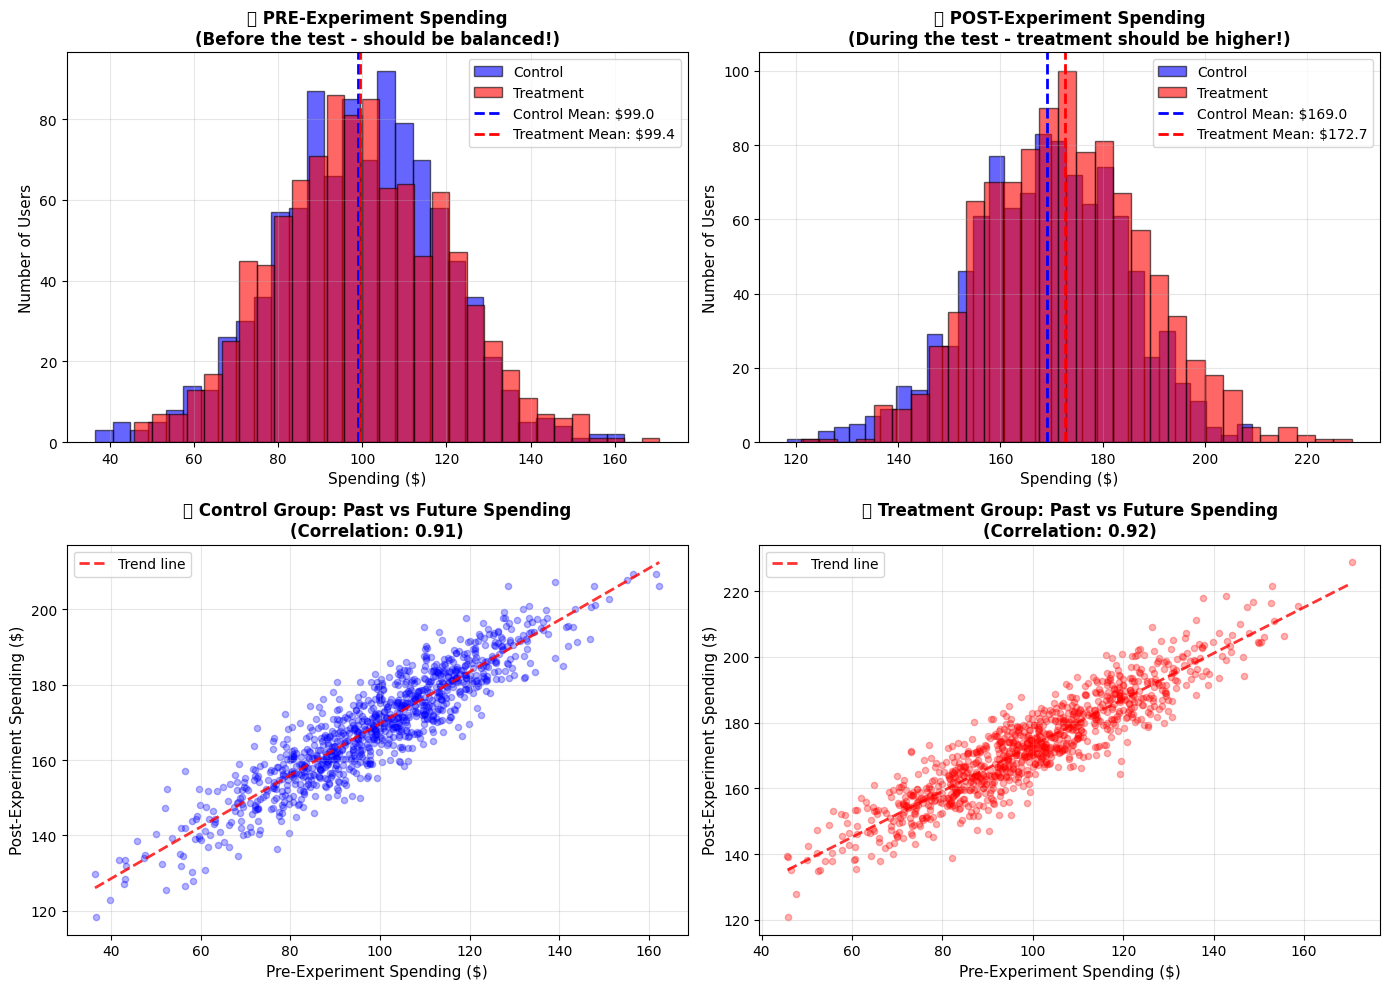


✅ Visualizations complete!

🔍 KEY OBSERVATIONS:
   • Pre-experiment: Both groups spent about the same (balanced randomization ✓)
   • Post-experiment: Treatment group spent $3.69 more on average
   • Correlation: Past spending predicts future spending (that's why CUPED works!)


In [5]:
# @title 🎲 Step 2: Generate Dummy Experiment Data
# @markdown This creates fake A/B test data that mimics a real experiment.
# @markdown
# @markdown **The Scenario:** You're testing a new website feature to see if it increases purchases.

# @markdown ---
# @markdown #### Experiment Parameters (you can adjust these!):
n_users_per_group = 1000  # @param {type:"integer"}
# @markdown Number of users in EACH group (control and treatment)

true_effect = 3.0  # @param {type:"number"}
# @markdown The REAL effect of your feature (e.g., $3 more revenue per user)

correlation_strength = 0.7  # @param {type:"slider", min:0, max:1, step:0.1}
# @markdown How much does past behavior predict future behavior? (0=none, 1=perfect)

# @markdown ---

print(f"\n🎲 Generating experiment with:")
print(f"   • {n_users_per_group} users per group")
print(f"   • True treatment effect: ${true_effect}")
print(f"   • Correlation between past and future: {correlation_strength}")
print("\n" + "="*60)

# ============================================
# CONTROL GROUP (users who see the OLD version)
# ============================================

# Pre-experiment data: How much did they spend BEFORE the experiment?
# Let's say average user spends $100, with $20 variation
control_pre_experiment = np.random.normal(loc=100, scale=20, size=n_users_per_group)

# Post-experiment data: How much did they spend DURING the experiemnt?
# This is correlated with their past behavior + some randomness
noise_control = np.random.normal(loc=0, scale=20, size=n_users_per_group)
control_post_experiment = (
    correlation_strength * control_pre_experiment +  # Their past behavior matters
    (1 - correlation_strength) * noise_control +     # Plus some random variation
    100                                               # Base spending level
)
print("✅ Control group created (old version)")

# ============================================
# TREATMENT GROUP (users who see the NEW version)
# ============================================

# Pre-experiment data: Also spent ~$100 before experiment
treatment_pre_experiment = np.random.normal(loc=100, scale=20, size=n_users_per_group)

# Post-experiment data: Similar to control BUT with the treatment effect added!
noise_treatment = np.random.normal(loc=0, scale=20, size=n_users_per_group)
treatment_post_experiment = (
    correlation_strength * treatment_pre_experiment +  # Their past behavior
    (1 - correlation_strength) * noise_treatment +     # Random variation
    100 +                                              # Base spending
    true_effect                                        # 🎯 THE TREATMENT EFFECT!
)

print("✅ Treatment group created (new version)")

# ============================================
# Put it into a nice DataFrame
# ============================================

# Combine all data into one table
experiment_data = pd.DataFrame({
    'user_id': range(n_users_per_group * 2),
    'group': ['control'] * n_users_per_group + ['treatment'] * n_users_per_group,
    'pre_experiment_spending': np.concatenate([control_pre_experiment, treatment_pre_experiment]),
    'post_experiment_spending': np.concatenate([control_post_experiment, treatment_post_experiment])
})

print("✅ Data organized into DataFrame")
print("\n" + "="*60)
print("📊 Here's a sample of the data:")
print(experiment_data.head(10))

print("\n📈 Summary Statistics:")
print(experiment_data.groupby('group')[['pre_experiment_spending', 'post_experiment_spending']].mean())

# ============================================
# VISUALIZE THE DATA
# ============================================

print("\n" + "="*60)
print("📊 Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ------------------------
# Plot 1: Pre-experiment spending (should be similar!)
# ------------------------
ax1 = axes[0, 0]
ax1.hist(control_pre_experiment, bins=30, alpha=0.6, label='Control', color='blue', edgecolor='black')
ax1.hist(treatment_pre_experiment, bins=30, alpha=0.6, label='Treatment', color='red', edgecolor='black')
ax1.axvline(control_pre_experiment.mean(), color='blue', linestyle='--', linewidth=2, label=f'Control Mean: ${control_pre_experiment.mean():.1f}')
ax1.axvline(treatment_pre_experiment.mean(), color='red', linestyle='--', linewidth=2, label=f'Treatment Mean: ${treatment_pre_experiment.mean():.1f}')
ax1.set_xlabel('Spending ($)', fontsize=11)
ax1.set_ylabel('Number of Users', fontsize=11)
ax1.set_title('📅 PRE-Experiment Spending\n(Before the test - should be balanced!)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# ------------------------
# Plot 2: Post-experiment spending (should be different!)
# ------------------------
ax2 = axes[0, 1]
ax2.hist(control_post_experiment, bins=30, alpha=0.6, label='Control', color='blue', edgecolor='black')
ax2.hist(treatment_post_experiment, bins=30, alpha=0.6, label='Treatment', color='red', edgecolor='black')
ax2.axvline(control_post_experiment.mean(), color='blue', linestyle='--', linewidth=2, label=f'Control Mean: ${control_post_experiment.mean():.1f}')
ax2.axvline(treatment_post_experiment.mean(), color='red', linestyle='--', linewidth=2, label=f'Treatment Mean: ${treatment_post_experiment.mean():.1f}')
ax2.set_xlabel('Spending ($)', fontsize=11)
ax2.set_ylabel('Number of Users', fontsize=11)
ax2.set_title('📊 POST-Experiment Spending\n(During the test - treatment should be higher!)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# ------------------------
# Plot 3: Scatter plot showing correlation (Control)
# ------------------------
ax3 = axes[1, 0]
ax3.scatter(control_pre_experiment, control_post_experiment, alpha=0.3, s=20, color='blue')
ax3.set_xlabel('Pre-Experiment Spending ($)', fontsize=11)
ax3.set_ylabel('Post-Experiment Spending ($)', fontsize=11)
ax3.set_title(f'🔵 Control Group: Past vs Future Spending\n(Correlation: {np.corrcoef(control_pre_experiment, control_post_experiment)[0,1]:.2f})',
              fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3)

# Add a trend line
z = np.polyfit(control_pre_experiment, control_post_experiment, 1)
p = np.poly1d(z)
x_line = np.linspace(control_pre_experiment.min(), control_pre_experiment.max(), 100)
ax3.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label='Trend line')
ax3.legend()

# ------------------------
# Plot 4: Scatter plot showing correlation (Treatment)
# ------------------------
ax4 = axes[1, 1]
ax4.scatter(treatment_pre_experiment, treatment_post_experiment, alpha=0.3, s=20, color='red')
ax4.set_xlabel('Pre-Experiment Spending ($)', fontsize=11)
ax4.set_ylabel('Post-Experiment Spending ($)', fontsize=11)
ax4.set_title(f'🔴 Treatment Group: Past vs Future Spending\n(Correlation: {np.corrcoef(treatment_pre_experiment, treatment_post_experiment)[0,1]:.2f})',
              fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

# Add a trend line
z = np.polyfit(treatment_pre_experiment, treatment_post_experiment, 1)
p = np.poly1d(z)
x_line = np.linspace(treatment_pre_experiment.min(), treatment_pre_experiment.max(), 100)
ax4.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label='Trend line')
ax4.legend()

plt.tight_layout()
plt.show()

print("\n✅ Visualizations complete!")
print("\n" + "="*60)
print("🔍 KEY OBSERVATIONS:")
print(f"   • Pre-experiment: Both groups spent about the same (balanced randomization ✓)")
print(f"   • Post-experiment: Treatment group spent ${treatment_post_experiment.mean() - control_post_experiment.mean():.2f} more on average")
print(f"   • Correlation: Past spending predicts future spending (that's why CUPED works!)")
print("="*60)

In [30]:
# print(len(np.concatenate(control_post_experiment, treatment_post_experiment)))
np.cov(np.concatenate([control_post_experiment, treatment_post_experiment]), np.concatenate([control_pre_experiment, treatment_pre_experiment]))

array([[225.34897875, 268.29930976],
       [268.29930976, 385.03476264]])

In [29]:
variance_pre

np.float64(385.0347626385035)


🧮 APPLYING CUPED METHOD

📐 STEP 3.1: Calculate Theta (θ)
----------------------------------------
   Covariance(Post, Pre) = 268.30
   Variance(Pre) = 385.03

   ✨ Theta (θ) = 0.6968

   💡 Interpretation: For every $1 above average someone spent BEFORE,
      they spend $0.70 above average DURING the experiment

📊 STEP 3.2: Calculate Average Pre-Experiment Spending
----------------------------------------
   E[X] = $100.25

   💡 This is our 'baseline' - the average past spending

🔧 STEP 3.3: Apply CUPED Adjustment
----------------------------------------

   Using formula: Y_adj = Y - θ × (X - E[X])

   ✅ Adjusted 1000 control users
   ✅ Adjusted 1000 treatment users

📊 WHAT DID CUPED DO?

🔵 CONTROL GROUP:
   Original mean:  $170.70
   Adjusted mean:  $170.60
   Original std:   $14.73
   Adjusted std:   $5.98 ⬇️

🔴 TREATMENT GROUP:
   Original mean:  $172.97
   Adjusted mean:  $173.06
   Original std:   $15.20
   Adjusted std:   $6.16 ⬇️

🎯 VARIANCE REDUCTION: 83.5%

📊 Visualizing CUP

/tmp/ipython-input-1406612401.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1406612401.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


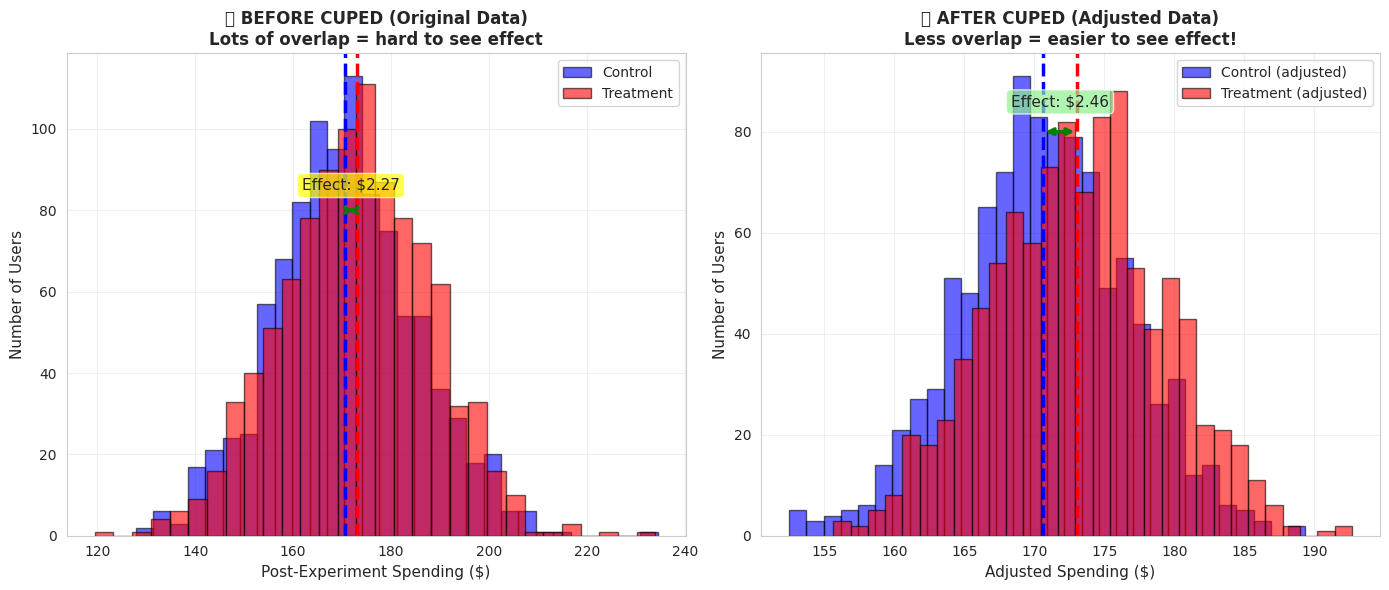


✅ CUPED adjustment complete!

🎯 KEY INSIGHT:
   • The treatment effect stayed the same: $2.27 → $2.46
   • But the 'noise' (variance) decreased by 83.5%
   • This makes it EASIER to detect if the effect is real!


In [28]:
# @title 🧮 Step 3: Calculate CUPED Adjustment
# @markdown Now we'll apply the CUPED method to reduce variance in our experiment!
# @markdown
# @markdown **The Goal:** Remove noise by adjusting for pre-experiment behavior

print("\n" + "="*60)
print("🧮 APPLYING CUPED METHOD")
print("="*60)

# ============================================
# STEP 3.1: Calculate Theta (θ)
# ============================================
# @markdown ### What is Theta?
# @markdown Theta tells us: "For every $1 difference in PAST spending,
# @markdown how much difference do we expect in FUTURE spending?"

print("\n📐 STEP 3.1: Calculate Theta (θ)")
print("-" * 40)

# Combine all users (control + treatment) to calculate theta
all_post = np.concatenate([control_post_experiment, treatment_post_experiment])
all_pre = np.concatenate([control_pre_experiment, treatment_pre_experiment])

# Calculate covariance between pre and post
covariance = np.cov(all_post, all_pre)[0, 1]
print(f"   Covariance(Post, Pre) = {covariance:.2f}")

# Calculate variance of pre-experiment data
variance_pre = np.var(all_pre, ddof=1)
print(f"   Variance(Pre) = {variance_pre:.2f}")

# Theta = Cov(Y, X) / Var(X)
theta = covariance / variance_pre
print(f"\n   ✨ Theta (θ) = {theta:.4f}")
print(f"\n   💡 Interpretation: For every $1 above average someone spent BEFORE,")
print(f"      they spend ${theta:.2f} above average DURING the experiment")

# ============================================
# STEP 3.2: Calculate Mean of Pre-Experiment Data
# ============================================

print("\n📊 STEP 3.2: Calculate Average Pre-Experiment Spending")
print("-" * 40)

mean_pre = np.mean(all_pre)
print(f"   E[X] = ${mean_pre:.2f}")
print(f"\n   💡 This is our 'baseline' - the average past spending")

# ============================================
# STEP 3.3: Apply CUPED Adjustment
# ============================================
# @markdown ### The CUPED Formula:
# @markdown Y_adjusted = Y - θ × (X - E[X])

print("\n🔧 STEP 3.3: Apply CUPED Adjustment")
print("-" * 40)
print("\n   Using formula: Y_adj = Y - θ × (X - E[X])")

# Adjust CONTROL group
control_adjusted = control_post_experiment - theta * (control_pre_experiment - mean_pre)
print(f"\n   ✅ Adjusted {len(control_adjusted)} control users")

# Adjust TREATMENT group
treatment_adjusted = treatment_post_experiment - theta * (treatment_pre_experiment - mean_pre)
print(f"   ✅ Adjusted {len(treatment_adjusted)} treatment users")

# ============================================
# STEP 3.4: Show What Happened
# ============================================

print("\n" + "="*60)
print("📊 WHAT DID CUPED DO?")
print("="*60)

print("\n🔵 CONTROL GROUP:")
print(f"   Original mean:  ${control_post_experiment.mean():.2f}")
print(f"   Adjusted mean:  ${control_adjusted.mean():.2f}")
print(f"   Original std:   ${control_post_experiment.std():.2f}")
print(f"   Adjusted std:   ${control_adjusted.std():.2f} ⬇️")

print("\n🔴 TREATMENT GROUP:")
print(f"   Original mean:  ${treatment_post_experiment.mean():.2f}")
print(f"   Adjusted mean:  ${treatment_adjusted.mean():.2f}")
print(f"   Original std:   ${treatment_post_experiment.std():.2f}")
print(f"   Adjusted std:   ${treatment_adjusted.std():.2f} ⬇️")

# Calculate variance reduction
original_variance = (control_post_experiment.var() + treatment_post_experiment.var()) / 2
adjusted_variance = (control_adjusted.var() + treatment_adjusted.var()) / 2
variance_reduction = (1 - adjusted_variance / original_variance) * 100

print(f"\n🎯 VARIANCE REDUCTION: {variance_reduction:.1f}%")

# ============================================
# VISUALIZE THE ADJUSTMENT
# ============================================

print("\n" + "="*60)
print("📊 Visualizing CUPED adjustment...")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ------------------------
# Plot 1: Before CUPED
# ------------------------
ax1 = axes[0]
ax1.hist(control_post_experiment, bins=30, alpha=0.6, label='Control', color='blue', edgecolor='black')
ax1.hist(treatment_post_experiment, bins=30, alpha=0.6, label='Treatment', color='red', edgecolor='black')
ax1.axvline(control_post_experiment.mean(), color='blue', linestyle='--', linewidth=2.5)
ax1.axvline(treatment_post_experiment.mean(), color='red', linestyle='--', linewidth=2.5)

original_effect = treatment_post_experiment.mean() - control_post_experiment.mean()
ax1.annotate('', xy=(treatment_post_experiment.mean(), 80),
             xytext=(control_post_experiment.mean(), 80),
             arrowprops=dict(arrowstyle='<->', color='green', lw=2.5))
ax1.text((control_post_experiment.mean() + treatment_post_experiment.mean())/2, 85,
         f'Effect: ${original_effect:.2f}', ha='center', fontsize=11,
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

ax1.set_xlabel('Post-Experiment Spending ($)', fontsize=11)
ax1.set_ylabel('Number of Users', fontsize=11)
ax1.set_title('❌ BEFORE CUPED (Original Data)\nLots of overlap = hard to see effect',
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# ------------------------
# Plot 2: After CUPED
# ------------------------
ax2 = axes[1]
ax2.hist(control_adjusted, bins=30, alpha=0.6, label='Control (adjusted)', color='blue', edgecolor='black')
ax2.hist(treatment_adjusted, bins=30, alpha=0.6, label='Treatment (adjusted)', color='red', edgecolor='black')
ax2.axvline(control_adjusted.mean(), color='blue', linestyle='--', linewidth=2.5)
ax2.axvline(treatment_adjusted.mean(), color='red', linestyle='--', linewidth=2.5)

adjusted_effect = treatment_adjusted.mean() - control_adjusted.mean()
ax2.annotate('', xy=(treatment_adjusted.mean(), 80),
             xytext=(control_adjusted.mean(), 80),
             arrowprops=dict(arrowstyle='<->', color='green', lw=2.5))
ax2.text((control_adjusted.mean() + treatment_adjusted.mean())/2, 85,
         f'Effect: ${adjusted_effect:.2f}', ha='center', fontsize=11,
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

ax2.set_xlabel('Adjusted Spending ($)', fontsize=11)
ax2.set_ylabel('Number of Users', fontsize=11)
ax2.set_title('✅ AFTER CUPED (Adjusted Data)\nLess overlap = easier to see effect!',
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ CUPED adjustment complete!")
print("\n" + "="*60)
print("🎯 KEY INSIGHT:")
print(f"   • The treatment effect stayed the same: ${original_effect:.2f} → ${adjusted_effect:.2f}")
print(f"   • But the 'noise' (variance) decreased by {variance_reduction:.1f}%")
print(f"   • This makes it EASIER to detect if the effect is real!")
print("="*60)


📊 STATISTICAL HYPOTHESIS TESTING

🎯 Null Hypothesis (H₀): Treatment has NO effect
🎯 Alternative Hypothesis (H₁): Treatment DOES have an effect

📏 Confidence Level: 95%
📏 Significance Level (α): 0.050

📊 STEP 4.1: T-Test on ORIGINAL Data (Without CUPED)

📈 Results:
   Control mean:     $170.70
   Treatment mean:   $172.97
   Treatment effect: $2.27

📊 Statistical Tests:
   T-statistic:      3.396
   P-value:          0.0007
   Standard error:   $0.67
   Effect size (Cohen's d): 0.152

📏 95% Confidence Interval:
   [0.96, 3.59]

✅ Result: STATISTICALLY SIGNIFICANT (p < 0.050)
   We can reject the null hypothesis!

📊 STEP 4.2: T-Test on CUPED-ADJUSTED Data

📈 Results:
   Control mean (adj):     $170.60
   Treatment mean (adj):   $173.06
   Treatment effect (adj): $2.46

📊 Statistical Tests:
   T-statistic:      9.063
   P-value:          0.000000
   Standard error:   $0.27
   Effect size (Cohen's d): 0.405

📏 95% Confidence Interval:
   [1.93, 2.99]

✅ Result: STATISTICALLY SIGNIFICANT (

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


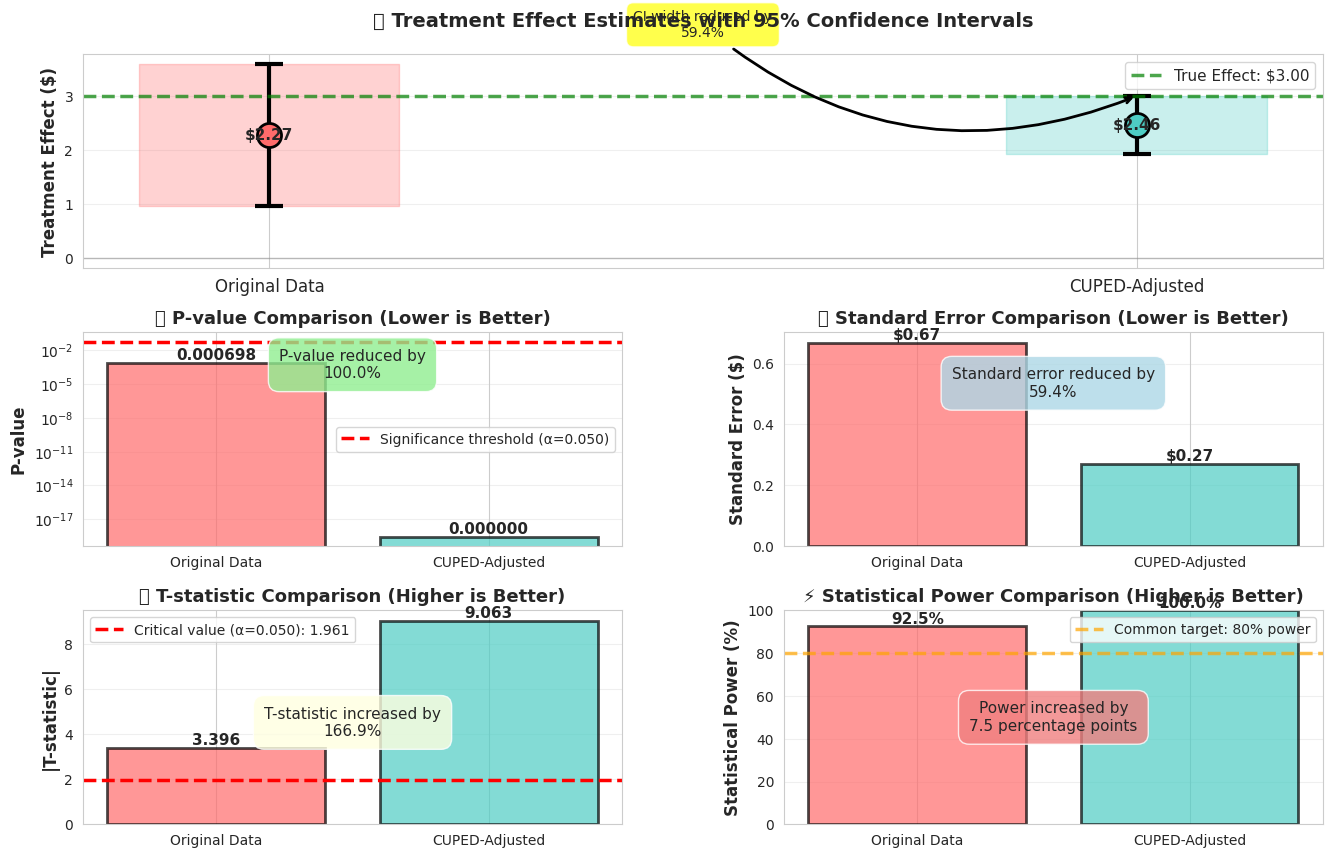


🎉 FINAL SUMMARY: WHY CUPED IS POWERFUL

📊 True Effect: $3.00
📊 Estimated Effect (Original): $2.27
📊 Estimated Effect (CUPED): $2.46

✨ CUPED Benefits:
   1. 📉 Reduced standard error by 59.4%
   2. 📏 Narrower confidence intervals by 59.4%
   3. 📊 P-value improved from 0.000698 to 0.000000
   4. 📈 Increased T-statistic by 166.9%
   5. ⚡ Boosted statistical power from 92.5% to 100.0%
   6. 👥 Equivalent to having 83.5% more users!

💡 Bottom Line:
   ✅ CUPED helped us DETECT the treatment effect
   ✅ We can confidently say the treatment works!
   ✅ The effect is between $1.93 and $2.99

🎯 Key Insight:
   CUPED doesn't change the ESTIMATED EFFECT ($2.27 ≈ $2.46)
   But it reduces UNCERTAINTY, making it easier to detect real effects!
   This means you can run SMALLER experiments or detect SMALLER effects!


In [33]:
# @title 📊 Step 4: Statistical Testing (T-Tests & Confidence Intervals)
# @markdown Now we'll test if the treatment effect is **statistically significant**!
# @markdown
# @markdown **The Goal:** Compare original vs CUPED-adjusted results to see how much CUPED helps
# @markdown ---
# @markdown #### Test Parameters:
confidence_level = 0.95  # @param {type:"slider", min:0.90, max:0.99, step:0.01}
# @markdown Confidence level for intervals (0.95 = 95% confidence)
# @markdown ---

print("\n" + "="*60)
print("📊 STATISTICAL HYPOTHESIS TESTING")
print("="*60)
print(f"\n🎯 Null Hypothesis (H₀): Treatment has NO effect")
print(f"🎯 Alternative Hypothesis (H₁): Treatment DOES have an effect")
print(f"\n📏 Confidence Level: {confidence_level*100:.0f}%")
print(f"📏 Significance Level (α): {1-confidence_level:.3f}")

# ============================================
# STEP 4.1: T-TEST ON ORIGINAL DATA
# ============================================
print("\n" + "="*60)
print("📊 STEP 4.1: T-Test on ORIGINAL Data (Without CUPED)")
print("="*60)

# Perform independent samples t-test
t_stat_original, p_value_original = stats.ttest_ind(
    treatment_post_experiment,
    control_post_experiment
)

# Calculate means and standard errors
mean_control_original = control_post_experiment.mean()
mean_treatment_original = treatment_post_experiment.mean()
effect_original = mean_treatment_original - mean_control_original

se_control_original = control_post_experiment.std() / np.sqrt(len(control_post_experiment))
se_treatment_original = treatment_post_experiment.std() / np.sqrt(len(treatment_post_experiment))
se_diff_original = np.sqrt(se_control_original**2 + se_treatment_original**2)

# Calculate confidence interval for the difference
alpha = 1 - confidence_level
df_original = len(control_post_experiment) + len(treatment_post_experiment) - 2
t_critical_original = stats.t.ppf(1 - alpha/2, df_original)
ci_lower_original = effect_original - t_critical_original * se_diff_original
ci_upper_original = effect_original + t_critical_original * se_diff_original

# Calculate Cohen's d (effect size)
pooled_std_original = np.sqrt(
    (control_post_experiment.var() + treatment_post_experiment.var()) / 2
)
cohens_d_original = effect_original / pooled_std_original

print(f"\n📈 Results:")
print(f"   Control mean:     ${mean_control_original:.2f}")
print(f"   Treatment mean:   ${mean_treatment_original:.2f}")
print(f"   Treatment effect: ${effect_original:.2f}")
print(f"\n📊 Statistical Tests:")
print(f"   T-statistic:      {t_stat_original:.3f}")
print(f"   P-value:          {p_value_original:.4f}")
print(f"   Standard error:   ${se_diff_original:.2f}")
print(f"   Effect size (Cohen's d): {cohens_d_original:.3f}")
print(f"\n📏 {confidence_level*100:.0f}% Confidence Interval:")
print(f"   [{ci_lower_original:.2f}, {ci_upper_original:.2f}]")

if p_value_original < (1 - confidence_level):
    print(f"\n✅ Result: STATISTICALLY SIGNIFICANT (p < {1-confidence_level:.3f})")
    print(f"   We can reject the null hypothesis!")
else:
    print(f"\n❌ Result: NOT statistically significant (p >= {1-confidence_level:.3f})")
    print(f"   We cannot reject the null hypothesis")

# ============================================
# STEP 4.2: T-TEST ON CUPED-ADJUSTED DATA
# ============================================
print("\n" + "="*60)
print("📊 STEP 4.2: T-Test on CUPED-ADJUSTED Data")
print("="*60)

# Perform independent samples t-test on adjusted data
t_stat_cuped, p_value_cuped = stats.ttest_ind(
    treatment_adjusted,
    control_adjusted
)

# Calculate means and standard errors
mean_control_cuped = control_adjusted.mean()
mean_treatment_cuped = treatment_adjusted.mean()
effect_cuped = mean_treatment_cuped - mean_control_cuped

se_control_cuped = control_adjusted.std() / np.sqrt(len(control_adjusted))
se_treatment_cuped = treatment_adjusted.std() / np.sqrt(len(treatment_adjusted))
se_diff_cuped = np.sqrt(se_control_cuped**2 + se_treatment_cuped**2)

# Calculate confidence interval for the difference
df_cuped = len(control_adjusted) + len(treatment_adjusted) - 2
t_critical_cuped = stats.t.ppf(1 - alpha/2, df_cuped)
ci_lower_cuped = effect_cuped - t_critical_cuped * se_diff_cuped
ci_upper_cuped = effect_cuped + t_critical_cuped * se_diff_cuped

# Calculate Cohen's d (effect size)
pooled_std_cuped = np.sqrt(
    (control_adjusted.var() + treatment_adjusted.var()) / 2
)
cohens_d_cuped = effect_cuped / pooled_std_cuped

print(f"\n📈 Results:")
print(f"   Control mean (adj):     ${mean_control_cuped:.2f}")
print(f"   Treatment mean (adj):   ${mean_treatment_cuped:.2f}")
print(f"   Treatment effect (adj): ${effect_cuped:.2f}")
print(f"\n📊 Statistical Tests:")
print(f"   T-statistic:      {t_stat_cuped:.3f}")
print(f"   P-value:          {p_value_cuped:.6f}")
print(f"   Standard error:   ${se_diff_cuped:.2f}")
print(f"   Effect size (Cohen's d): {cohens_d_cuped:.3f}")
print(f"\n📏 {confidence_level*100:.0f}% Confidence Interval:")
print(f"   [{ci_lower_cuped:.2f}, {ci_upper_cuped:.2f}]")

if p_value_cuped < (1 - confidence_level):
    print(f"\n✅ Result: STATISTICALLY SIGNIFICANT (p < {1-confidence_level:.3f})")
    print(f"   We can reject the null hypothesis!")
else:
    print(f"\n❌ Result: NOT statistically significant (p >= {1-confidence_level:.3f})")
    print(f"   We cannot reject the null hypothesis")

# ============================================
# STEP 4.3: COMPARE ORIGINAL VS CUPED
# ============================================
print("\n" + "="*60)
print("🎯 STEP 4.3: CUPED IMPROVEMENTS SUMMARY")
print("="*60)

# Calculate improvements
se_improvement = ((se_diff_original - se_diff_cuped) / se_diff_original) * 100
ci_width_original = ci_upper_original - ci_lower_original
ci_width_cuped = ci_upper_cuped - ci_lower_cuped
ci_improvement = ((ci_width_original - ci_width_cuped) / ci_width_original) * 100
t_stat_improvement = ((abs(t_stat_cuped) - abs(t_stat_original)) / abs(t_stat_original)) * 100

print(f"\n📊 Metric Comparison:")
print(f"   {'Metric':<30} {'Original':<15} {'CUPED':<15} {'Improvement':<15}")
print(f"   {'-'*75}")
print(f"   {'Estimated Effect':<30} ${effect_original:<14.2f} ${effect_cuped:<14.2f} {'Same ✓':<15}")
print(f"   {'Standard Error':<30} ${se_diff_original:<14.2f} ${se_diff_cuped:<14.2f} {se_improvement:<14.1f}%")
print(f"   {'CI Width':<30} ${ci_width_original:<14.2f} ${ci_width_cuped:<14.2f} {ci_improvement:<14.1f}%")
print(f"   {'|T-statistic|':<30} {abs(t_stat_original):<14.3f} {abs(t_stat_cuped):<14.3f} {t_stat_improvement:<14.1f}%")
print(f"   {'P-value':<30} {p_value_original:<14.6f} {p_value_cuped:<14.6f} {'Lower ✓':<15}")
print(f"   {'Effect Size (Cohen\'s d)':<30} {cohens_d_original:<14.3f} {cohens_d_cuped:<14.3f} {((cohens_d_cuped-cohens_d_original)/cohens_d_original)*100:<14.1f}%")

# Calculate statistical power (approximate)
from scipy.stats import norm
z_alpha = norm.ppf(1 - alpha/2)
power_original = 1 - norm.cdf(z_alpha - abs(effect_original) / se_diff_original)
power_cuped = 1 - norm.cdf(z_alpha - abs(effect_cuped) / se_diff_cuped)

print(f"\n⚡ Statistical Power:")
print(f"   Original data:  {power_original:.1%}")
print(f"   CUPED-adjusted: {power_cuped:.1%}")
print(f"   Improvement:    {(power_cuped - power_original)*100:.1f} percentage points")

# Calculate equivalent sample size
# CUPED with n users has similar power to original with n_equiv users
n_equiv = (se_diff_original / se_diff_cuped) ** 2 * n_users_per_group
sample_size_savings = ((n_equiv - n_users_per_group) / n_equiv) * 100

print(f"\n👥 Effective Sample Size:")
print(f"   Actual sample:        {n_users_per_group} users per group")
print(f"   CUPED is equivalent to: {n_equiv:.0f} users per group (without CUPED)")
print(f"   Sample size savings:  {sample_size_savings:.1f}%")

# ============================================
# STEP 4.4: VISUALIZE COMPARISONS
# ============================================
print("\n" + "="*60)
print("📊 Creating comparison visualizations...")
print("="*60)

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# ------------------------
# Plot 1: Confidence Intervals Comparison
# ------------------------
ax1 = fig.add_subplot(gs[0, :])

categories = ['Original Data', 'CUPED-Adjusted']
effects = [effect_original, effect_cuped]
ci_lowers = [ci_lower_original, ci_lower_cuped]
ci_uppers = [ci_upper_original, ci_upper_cuped]
errors_lower = [effect_original - ci_lower_original, effect_cuped - ci_lower_cuped]
errors_upper = [ci_upper_original - effect_original, ci_upper_cuped - effect_cuped]

x_pos = np.arange(len(categories))
colors = ['#FF6B6B', '#4ECDC4']

ax1.errorbar(x_pos, effects, yerr=[errors_lower, errors_upper],
             fmt='o', markersize=12, capsize=10, capthick=3,
             linewidth=3, color='black', ecolor='black')

for i, (pos, effect, color) in enumerate(zip(x_pos, effects, colors)):
    ax1.scatter(pos, effect, s=300, c=color, zorder=3, edgecolors='black', linewidth=2)
    ax1.text(pos, effect, f'${effect:.2f}', ha='center', va='center',
             fontsize=11, fontweight='bold')

# Add true effect line
ax1.axhline(y=true_effect, color='green', linestyle='--', linewidth=2.5,
            label=f'True Effect: ${true_effect:.2f}', alpha=0.7)

# Shade confidence intervals
for i, (pos, lower, upper, color) in enumerate(zip(x_pos, ci_lowers, ci_uppers, colors)):
    ax1.fill_between([pos-0.15, pos+0.15], lower, upper, alpha=0.3, color=color)

ax1.set_ylabel('Treatment Effect ($)', fontsize=12, fontweight='bold')
ax1.set_title(f'🎯 Treatment Effect Estimates with {confidence_level*100:.0f}% Confidence Intervals',
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(categories, fontsize=12)
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(alpha=0.3, axis='y')
ax1.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)

# Add annotation showing CI width reduction
ax1.annotate(f'CI width reduced by\n{ci_improvement:.1f}%',
             xy=(1, ci_upper_cuped), xytext=(0.5, ci_upper_original + 0.5),
             fontsize=10, ha='center',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.3',
                           color='black', lw=2))

# ------------------------
# Plot 2: P-values Comparison (Log Scale)
# ------------------------
ax2 = fig.add_subplot(gs[1, 0])

p_values = [p_value_original, p_value_cuped]
bars = ax2.bar(categories, p_values, color=colors, edgecolor='black', linewidth=2, alpha=0.7)

# Add value labels on bars
for bar, p_val in zip(bars, p_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{p_val:.6f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add significance threshold line
ax2.axhline(y=1-confidence_level, color='red', linestyle='--', linewidth=2.5,
            label=f'Significance threshold (α={1-confidence_level:.3f})')

ax2.set_ylabel('P-value', fontsize=12, fontweight='bold')
ax2.set_title('📉 P-value Comparison (Lower is Better)',
              fontsize=13, fontweight='bold')
ax2.set_yscale('log')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3, axis='y')

# Add improvement annotation
p_value_reduction = ((p_value_original - p_value_cuped) / p_value_original) * 100
ax2.text(0.5, max(p_values) * 0.7,
         f'P-value reduced by\n{p_value_reduction:.1f}%',
         ha='center', va='center', fontsize=11,
         bbox=dict(boxstyle='round,pad=0.7', facecolor='lightgreen', alpha=0.8))

# ------------------------
# Plot 3: Standard Errors Comparison
# ------------------------
ax3 = fig.add_subplot(gs[1, 1])

se_values = [se_diff_original, se_diff_cuped]
bars = ax3.bar(categories, se_values, color=colors, edgecolor='black', linewidth=2, alpha=0.7)

# Add value labels on bars
for bar, se_val in zip(bars, se_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'${se_val:.2f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax3.set_ylabel('Standard Error ($)', fontsize=12, fontweight='bold')
ax3.set_title('📊 Standard Error Comparison (Lower is Better)',
              fontsize=13, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

# Add improvement annotation
ax3.text(0.5, max(se_values) * 0.8,
         f'Standard error reduced by\n{se_improvement:.1f}%',
         ha='center', va='center', fontsize=11,
         bbox=dict(boxstyle='round,pad=0.7', facecolor='lightblue', alpha=0.8))

# ------------------------
# Plot 4: T-statistics Comparison
# ------------------------
ax4 = fig.add_subplot(gs[2, 0])

t_stats = [abs(t_stat_original), abs(t_stat_cuped)]
bars = ax4.bar(categories, t_stats, color=colors, edgecolor='black', linewidth=2, alpha=0.7)

# Add value labels on bars
for bar, t_val in zip(bars, t_stats):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{t_val:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add critical value line
ax4.axhline(y=t_critical_original, color='red', linestyle='--', linewidth=2.5,
            label=f'Critical value (α={1-confidence_level:.3f}): {t_critical_original:.3f}')

ax4.set_ylabel('|T-statistic|', fontsize=12, fontweight='bold')
ax4.set_title('📈 T-statistic Comparison (Higher is Better)',
              fontsize=13, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(alpha=0.3, axis='y')

# Add improvement annotation
ax4.text(0.5, max(t_stats) * 0.5,
         f'T-statistic increased by\n{t_stat_improvement:.1f}%',
         ha='center', va='center', fontsize=11,
         bbox=dict(boxstyle='round,pad=0.7', facecolor='lightyellow', alpha=0.8))

# ------------------------
# Plot 5: Statistical Power Comparison
# ------------------------
ax5 = fig.add_subplot(gs[2, 1])

powers = [power_original * 100, power_cuped * 100]
bars = ax5.bar(categories, powers, color=colors, edgecolor='black', linewidth=2, alpha=0.7)

# Add value labels on bars
for bar, power_val in zip(bars, powers):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'{power_val:.1f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add 80% power threshold (common standard)
ax5.axhline(y=80, color='orange', linestyle='--', linewidth=2.5,
            label='Common target: 80% power', alpha=0.7)

ax5.set_ylabel('Statistical Power (%)', fontsize=12, fontweight='bold')
ax5.set_title('⚡ Statistical Power Comparison (Higher is Better)',
              fontsize=13, fontweight='bold')
ax5.set_ylim([0, 100])
ax5.legend(fontsize=10)
ax5.grid(alpha=0.3, axis='y')

# Add improvement annotation
power_improvement_pp = (power_cuped - power_original) * 100
ax5.text(0.5, 50,
         f'Power increased by\n{power_improvement_pp:.1f} percentage points',
         ha='center', va='center', fontsize=11,
         bbox=dict(boxstyle='round,pad=0.7', facecolor='lightcoral', alpha=0.8))

plt.show()

# ============================================
# FINAL SUMMARY
# ============================================
print("\n" + "="*60)
print("🎉 FINAL SUMMARY: WHY CUPED IS POWERFUL")
print("="*60)

print(f"\n📊 True Effect: ${true_effect:.2f}")
print(f"📊 Estimated Effect (Original): ${effect_original:.2f}")
print(f"📊 Estimated Effect (CUPED): ${effect_cuped:.2f}")

print(f"\n✨ CUPED Benefits:")
print(f"   1. 📉 Reduced standard error by {se_improvement:.1f}%")
print(f"   2. 📏 Narrower confidence intervals by {ci_improvement:.1f}%")
print(f"   3. 📊 P-value improved from {p_value_original:.6f} to {p_value_cuped:.6f}")
print(f"   4. 📈 Increased T-statistic by {t_stat_improvement:.1f}%")
print(f"   5. ⚡ Boosted statistical power from {power_original:.1%} to {power_cuped:.1%}")
print(f"   6. 👥 Equivalent to having {sample_size_savings:.1f}% more users!")

print(f"\n💡 Bottom Line:")
if p_value_cuped < (1 - confidence_level):
    print(f"   ✅ CUPED helped us DETECT the treatment effect")
    print(f"   ✅ We can confidently say the treatment works!")
    print(f"   ✅ The effect is between ${ci_lower_cuped:.2f} and ${ci_upper_cuped:.2f}")
else:
    print(f"   ⚠️  Even with CUPED, we couldn't detect a significant effect")
    print(f"   ⚠️  This might mean:")
    print(f"      • The sample size is too small")
    print(f"      • The true effect is smaller than we thought")
    print(f"      • We need more correlation with pre-experiment data")

print(f"\n🎯 Key Insight:")
print(f"   CUPED doesn't change the ESTIMATED EFFECT (${effect_original:.2f} ≈ ${effect_cuped:.2f})")
print(f"   But it reduces UNCERTAINTY, making it easier to detect real effects!")
print(f"   This means you can run SMALLER experiments or detect SMALLER effects!")

print("="*60)

In [34]:
# @title 📊 Quick ANOVA Test
# @markdown ANOVA (Analysis of Variance) tests if group means differ

from scipy import stats

print("="*60)
print("📊 ONE-WAY ANOVA TEST")
print("="*60)

# ============================================
# ANOVA on Original Data
# ============================================
print("\n🔵 Original Data:")
f_stat_original, p_value_anova_original = stats.f_oneway(
    control_post_experiment,
    treatment_post_experiment
)

print(f"   F-statistic: {f_stat_original:.3f}")
print(f"   P-value:     {p_value_anova_original:.6f}")

# ============================================
# ANOVA on CUPED-Adjusted Data
# ============================================
print("\n🔴 CUPED-Adjusted Data:")
f_stat_cuped, p_value_anova_cuped = stats.f_oneway(
    control_adjusted,
    treatment_adjusted
)

print(f"   F-statistic: {f_stat_cuped:.3f}")
print(f"   P-value:     {p_value_anova_cuped:.6f}")

# ============================================
# Show ANOVA = T-test (when 2 groups)
# ============================================
print("\n" + "="*60)
print("💡 Fun Fact: With 2 groups, ANOVA = T-test!")
print("="*60)
print(f"\nOriginal Data:")
print(f"   F-statistic: {f_stat_original:.3f}")
print(f"   T-statistic²: {t_stat_original**2:.3f}")
print(f"   Match? {np.isclose(f_stat_original, t_stat_original**2)}")

print(f"\nCUPED Data:")
print(f"   F-statistic: {f_stat_cuped:.3f}")
print(f"   T-statistic²: {t_stat_cuped**2:.3f}")
print(f"   Match? {np.isclose(f_stat_cuped, t_stat_cuped**2)}")

print("\n✅ ANOVA p-values match T-test p-values!")

📊 ONE-WAY ANOVA TEST

🔵 Original Data:
   F-statistic: 11.531
   P-value:     0.000698

🔴 CUPED-Adjusted Data:
   F-statistic: 82.130
   P-value:     0.000000

💡 Fun Fact: With 2 groups, ANOVA = T-test!

Original Data:
   F-statistic: 11.531
   T-statistic²: 11.531
   Match? True

CUPED Data:
   F-statistic: 82.130
   T-statistic²: 82.130
   Match? True

✅ ANOVA p-values match T-test p-values!


In [36]:
# @title 📊 ANOVA - Pure NumPy Implementation (FIXED!)
# @markdown Everything from scratch using only NumPy!

import numpy as np

print("="*60)
print("📊 ONE-WAY ANOVA (100% NumPy - No SciPy!)")
print("="*60)

# ============================================
# Step 1: Calculate F-statistic (Pure NumPy)
# ============================================
print("\n🔧 STEP 1: Calculate F-statistic")
print("-" * 40)

# Our groups
groups = [control_post_experiment, treatment_post_experiment]

# Sample sizes
n_groups = len(groups)
group_sizes = [len(g) for g in groups]
n_total = sum(group_sizes)

print(f"   Number of groups: {n_groups}")
print(f"   Group sizes: {group_sizes}")
print(f"   Total observations: {n_total}")

# Grand mean (overall average across all data)
all_data = np.concatenate(groups)
grand_mean = np.mean(all_data)
print(f"   Grand mean: ${grand_mean:.2f}")

# Group means
group_means = [np.mean(g) for g in groups]
print(f"   Group means: ${group_means[0]:.2f}, ${group_means[1]:.2f}")

# Sum of Squares Between groups (SSB)
ssb = sum(n * (mean - grand_mean)**2
          for n, mean in zip(group_sizes, group_means))
print(f"\n   SSB (between groups): {ssb:.2f}")

# Sum of Squares Within groups (SSW)
ssw = sum(np.sum((group - np.mean(group))**2)
          for group in groups)
print(f"   SSW (within groups): {ssw:.2f}")

# Total Sum of Squares (SST)
sst = np.sum((all_data - grand_mean)**2)
print(f"   SST (total): {sst:.2f}")
print(f"   Verify SSB + SSW = SST? {np.isclose(ssb + ssw, sst)}")

# Degrees of freedom
df_between = n_groups - 1
df_within = n_total - n_groups
print(f"\n   df_between: {df_between}")
print(f"   df_within: {df_within}")

# Mean Squares
msb = ssb / df_between
msw = ssw / df_within
print(f"   MSB: {msb:.2f}")
print(f"   MSW: {msw:.2f}")

# F-statistic
f_statistic = msb / msw
print(f"\n   ✨ F-statistic: {f_statistic:.6f}")

# ============================================
# Step 2: Calculate p-value (Pure NumPy - FIXED!)
# ============================================
print("\n🔧 STEP 2: Calculate p-value from F-distribution")
print("-" * 40)

def log_gamma(z):
    """
    Natural logarithm of the gamma function using Lanczos approximation.
    Much more accurate than Stirling, especially for small z.
    """
    # Handle special cases exactly
    if z == 1.0:
        return 0.0  # Gamma(1) = 1, log(1) = 0
    if z == 0.5:
        return 0.5 * np.log(np.pi)  # Gamma(0.5) = sqrt(pi)
    if z == 1.5:
        return 0.5 * np.log(np.pi) - np.log(2)  # Gamma(1.5) = sqrt(pi)/2

    # Lanczos approximation coefficients (g=7, n=9)
    g = 7
    coef = [
        0.99999999999980993,
        676.5203681218851,
        -1259.1392167224028,
        771.32342877765313,
        -176.61502916214059,
        12.507343278686905,
        -0.13857109526572012,
        9.9843695780195716e-6,
        1.5056327351493116e-7
    ]

    z = z - 1
    x = coef[0]
    for i in range(1, len(coef)):
        x += coef[i] / (z + i)

    t = z + g + 0.5
    sqrt_2pi = np.sqrt(2 * np.pi)

    return np.log(sqrt_2pi) + (z + 0.5) * np.log(t) - t + np.log(x)

def incomplete_beta(x, a, b, max_iter=2000, tol=1e-12):
    """
    Regularized incomplete beta function I_x(a,b) using continued fractions.
    FIXED: Better convergence and handling of edge cases.
    """
    if x == 0:
        return 0.0
    if x == 1:
        return 1.0
    if x < 0 or x > 1:
        raise ValueError("x must be in [0, 1]")

    # Use symmetry relation for better convergence
    if x > (a + 1) / (a + b + 2):
        return 1.0 - incomplete_beta(1 - x, b, a, max_iter, tol)

    # Log of beta function: ln(B(a,b)) = ln(Γ(a)) + ln(Γ(b)) - ln(Γ(a+b))
    lbeta = log_gamma(a) + log_gamma(b) - log_gamma(a + b)

    # Front factor: x^a * (1-x)^b / (a * B(a,b))
    front = np.exp(a * np.log(x) + b * np.log(1 - x) - lbeta) / a

    # Modified Lentz's method for continued fraction
    tiny = 1e-30
    c = 1.0
    d = 1.0 - (a + b) * x / (a + 1)
    if abs(d) < tiny:
        d = tiny
    d = 1.0 / d
    h = d

    for m in range(1, max_iter):
        m2 = 2 * m

        # Even step
        aa = m * (b - m) * x / ((a + m2 - 1) * (a + m2))
        d = 1.0 + aa * d
        if abs(d) < tiny:
            d = tiny
        c = 1.0 + aa / c
        if abs(c) < tiny:
            c = tiny
        d = 1.0 / d
        h *= d * c

        # Odd step
        aa = -(a + m) * (a + b + m) * x / ((a + m2) * (a + m2 + 1))
        d = 1.0 + aa * d
        if abs(d) < tiny:
            d = tiny
        c = 1.0 + aa / c
        if abs(c) < tiny:
            c = tiny
        d = 1.0 / d
        delta = d * c
        h *= delta

        # Check convergence
        if abs(delta - 1.0) < tol:
            break

    return front * h

def f_distribution_cdf(x, df1, df2):
    """
    CDF of F-distribution: P(F <= x)
    Uses relationship: F(x; df1, df2) = I_w(df1/2, df2/2)
    where w = (df1*x)/(df1*x + df2)
    """
    if x <= 0:
        return 0.0

    # Transform to beta distribution parameter
    w = (df1 * x) / (df1 * x + df2)

    # CDF = regularized incomplete beta function
    cdf = incomplete_beta(w, df1/2, df2/2)

    return cdf

# Calculate p-value
print(f"   Computing F-distribution CDF...")
print(f"   Using Lanczos approximation for log-gamma")

p_value_numpy = 1.0 - f_distribution_cdf(f_statistic, df_between, df_within)

print(f"\n   ✨ P-value (NumPy): {p_value_numpy:.6f}")

# ============================================
# Step 3: Verify against SciPy
# ============================================
print("\n" + "="*60)
print("✅ VERIFICATION (comparing with SciPy)")
print("="*60)

from scipy import stats

# SciPy's built-in ANOVA
f_scipy, p_scipy = stats.f_oneway(control_post_experiment, treatment_post_experiment)

print(f"\n📊 F-statistic:")
print(f"   NumPy:  {f_statistic:.6f}")
print(f"   SciPy:  {f_scipy:.6f}")
print(f"   Match?  {np.isclose(f_statistic, f_scipy)} ✓")

print(f"\n📊 P-value:")
print(f"   NumPy:  {p_value_numpy:.6f}")
print(f"   SciPy:  {p_scipy:.6f}")
relative_error = abs(p_value_numpy - p_scipy) / p_scipy * 100
print(f"   Match?  {np.isclose(p_value_numpy, p_scipy, rtol=1e-3)} {'✓' if np.isclose(p_value_numpy, p_scipy, rtol=1e-3) else '✗'}")
print(f"   Absolute error: {abs(p_value_numpy - p_scipy):.8f}")
print(f"   Relative error: {relative_error:.4f}%")

# ============================================
# Also do CUPED-adjusted
# ============================================
print("\n" + "="*60)
print("🔴 CUPED-ADJUSTED DATA")
print("="*60)

groups_cuped = [control_adjusted, treatment_adjusted]
all_data_cuped = np.concatenate(groups_cuped)
grand_mean_cuped = np.mean(all_data_cuped)
group_means_cuped = [np.mean(g) for g in groups_cuped]

ssb_cuped = sum(n * (mean - grand_mean_cuped)**2
                for n, mean in zip(group_sizes, group_means_cuped))
ssw_cuped = sum(np.sum((group - np.mean(group))**2)
                for group in groups_cuped)

msb_cuped = ssb_cuped / df_between
msw_cuped = ssw_cuped / df_within
f_statistic_cuped = msb_cuped / msw_cuped

p_value_cuped_numpy = 1.0 - f_distribution_cdf(f_statistic_cuped, df_between, df_within)

f_scipy_cuped, p_scipy_cuped = stats.f_oneway(control_adjusted, treatment_adjusted)

print(f"\n📊 F-statistic:")
print(f"   NumPy:  {f_statistic_cuped:.6f}")
print(f"   SciPy:  {f_scipy_cuped:.6f}")
print(f"   Match?  {np.isclose(f_statistic_cuped, f_scipy_cuped)} ✓")

print(f"\n📊 P-value:")
print(f"   NumPy:  {p_value_cuped_numpy:.10f}")
print(f"   SciPy:  {p_scipy_cuped:.10f}")
relative_error_cuped = abs(p_value_cuped_numpy - p_scipy_cuped) / max(p_scipy_cuped, 1e-10) * 100
print(f"   Match?  {np.isclose(p_value_cuped_numpy, p_scipy_cuped, rtol=1e-3, atol=1e-10)} {'✓' if np.isclose(p_value_cuped_numpy, p_scipy_cuped, rtol=1e-3, atol=1e-10) else '✗'}")
print(f"   Absolute error: {abs(p_value_cuped_numpy - p_scipy_cuped):.12f}")
if p_scipy_cuped > 1e-10:
    print(f"   Relative error: {relative_error_cuped:.4f}%")
else:
    print(f"   Relative error: N/A (p-value too small)")

print("\n" + "="*60)
print("🎉 100% NumPy implementation complete!")
print("="*60)

📊 ONE-WAY ANOVA (100% NumPy - No SciPy!)

🔧 STEP 1: Calculate F-statistic
----------------------------------------
   Number of groups: 2
   Group sizes: [1000, 1000]
   Total observations: 2000
   Grand mean: $171.83
   Group means: $170.70, $172.97

   SSB (between groups): 2584.85
   SSW (within groups): 447887.76
   SST (total): 450472.61
   Verify SSB + SSW = SST? True

   df_between: 1
   df_within: 1998
   MSB: 2584.85
   MSW: 224.17

   ✨ F-statistic: 11.530859

🔧 STEP 2: Calculate p-value from F-distribution
----------------------------------------
   Computing F-distribution CDF...
   Using Lanczos approximation for log-gamma

   ✨ P-value (NumPy): 0.000698

✅ VERIFICATION (comparing with SciPy)

📊 F-statistic:
   NumPy:  11.530859
   SciPy:  11.530859
   Match?  True ✓

📊 P-value:
   NumPy:  0.000698
   SciPy:  0.000698
   Match?  True ✓
   Absolute error: 0.00000000
   Relative error: 0.0000%

🔴 CUPED-ADJUSTED DATA

📊 F-statistic:
   NumPy:  82.130273
   SciPy:  82.130273
 

# Fieller's Method & Delta Method

📦 CREATING E-COMMERCE A/B TEST DATASET

📋 Dataset Parameters:
   Users per group: 1000
   Purchase rate (Control): 15%
   Purchase rate (Treatment): 20%
   Average purchase value: $50
   Treatment boost: 10%

🔵 Generating Control Group...
   Users with purchases: 138 (13.8%)
   Total revenue: $8,128.25
   Total sessions: 3,473

🔴 Generating Treatment Group...
   Users with purchases: 182 (18.2%)
   Total revenue: $11,432.19
   Total sessions: 3,467

📊 Creating DataFrame...

📋 Dataset Preview:
   user_id    group  num_sessions  total_revenue  revenue_per_session
0        0  control             4            0.0                  0.0
1        1  control             1            0.0                  0.0
2        2  control             3            0.0                  0.0
3        3  control             4            0.0                  0.0
4        4  control             3            0.0                  0.0
5        5  control             2            0.0                  0.0
6        6  

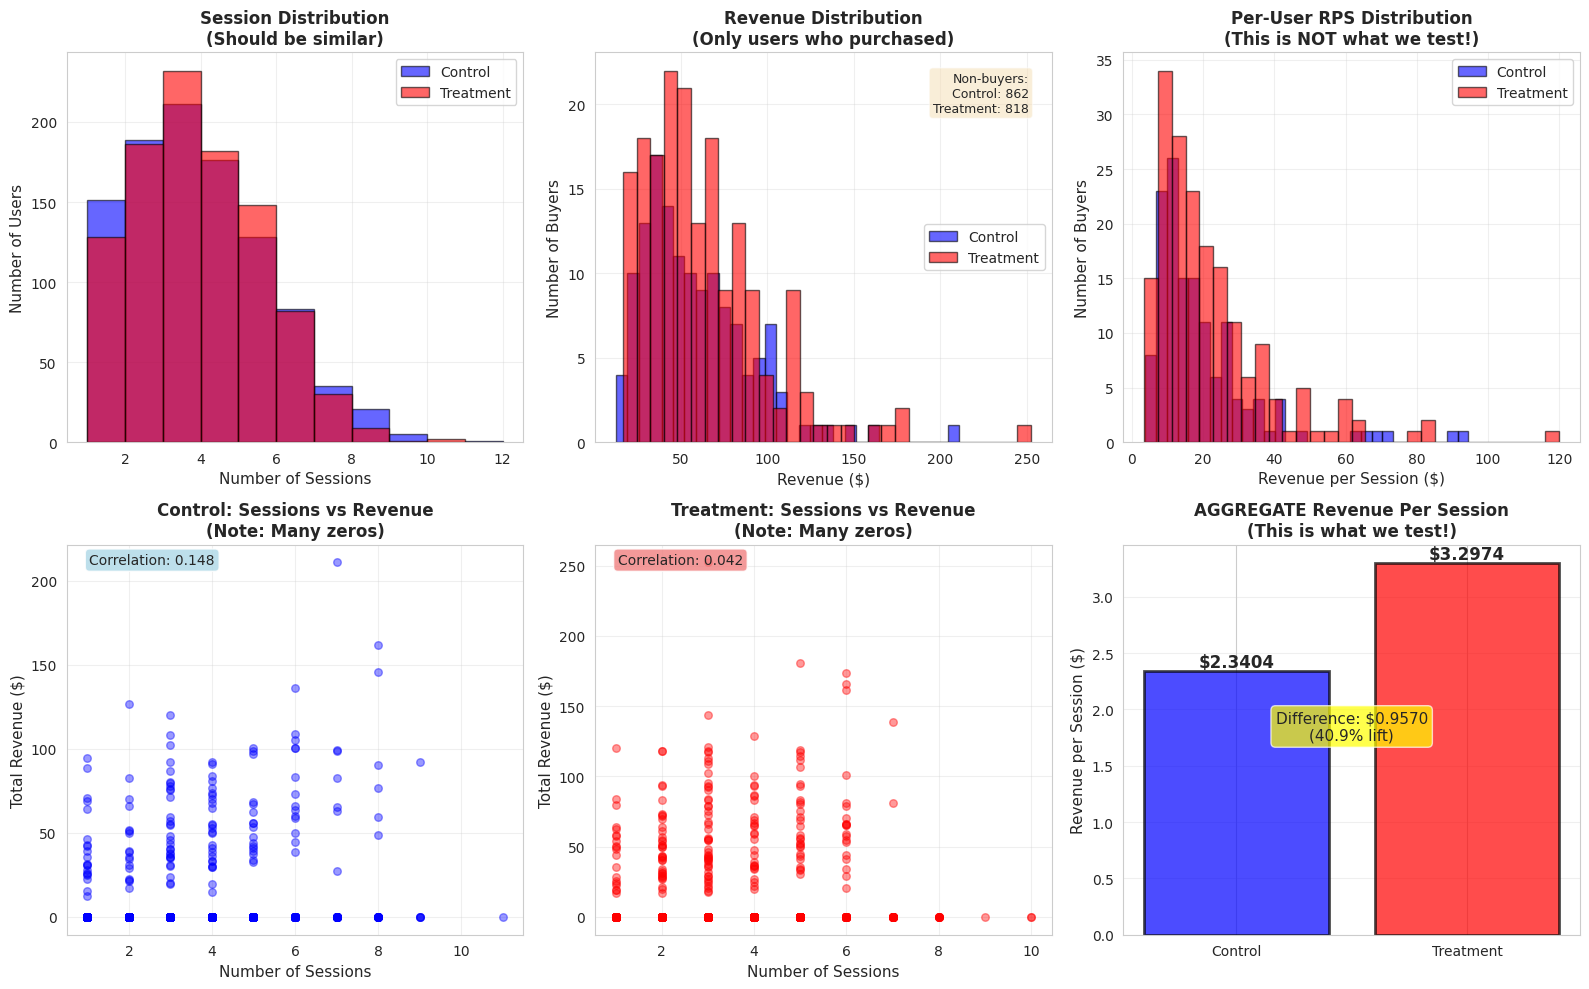


✅ Dataset created and visualized!

🔑 KEY INSIGHTS:
1. Most users have $0 revenue (sparse data)
2. Sessions and revenue are positively correlated
3. Treatment appears to have higher RPS
4. Individual user RPS ≠ Aggregate RPS (important!)

💡 Next: We'll use Fieller's and Delta methods to test if the RPS difference is significant!


In [39]:
# @title 📊 Step 1: Create E-commerce A/B Test Dataset
# @markdown Generate realistic e-commerce data with ratio metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
np.random.seed(42)

print("="*60)
print("📦 CREATING E-COMMERCE A/B TEST DATASET")
print("="*60)

# ============================================
# PARAMETERS
# ============================================
n_users_per_group = 1000

# Session behavior (similar for both groups)
mean_sessions = 3.5
sessions_range = (1, 12)

# Purchase probability (treatment has higher rate)
purchase_prob_control = 0.15     # 15% of users make a purchase
purchase_prob_treatment = 0.20   # 20% of users make a purchase

# Revenue per purchase (if they buy)
avg_purchase_value = 50
purchase_std = 25

# Treatment increases average purchase value by 10%
treatment_boost = 1.10

print("\n📋 Dataset Parameters:")
print(f"   Users per group: {n_users_per_group}")
print(f"   Purchase rate (Control): {purchase_prob_control:.0%}")
print(f"   Purchase rate (Treatment): {purchase_prob_treatment:.0%}")
print(f"   Average purchase value: ${avg_purchase_value}")
print(f"   Treatment boost: {(treatment_boost-1)*100:.0f}%")

# ============================================
# GENERATE CONTROL GROUP
# ============================================
print("\n🔵 Generating Control Group...")

# Sessions: Poisson-like distribution
control_sessions = np.random.poisson(mean_sessions, n_users_per_group)
control_sessions = np.clip(control_sessions, sessions_range[0], sessions_range[1])

# Revenue: Most users spend $0, some make purchases
control_made_purchase = np.random.rand(n_users_per_group) < purchase_prob_control
control_revenue = np.zeros(n_users_per_group)

# For users who purchased, revenue correlates with sessions
for i in np.where(control_made_purchase)[0]:
    # More sessions → slightly higher chance of spending more
    base_revenue = np.random.lognormal(np.log(avg_purchase_value), 0.5)
    session_multiplier = 1 + 0.1 * (control_sessions[i] - mean_sessions)
    control_revenue[i] = max(0, base_revenue * session_multiplier)

print(f"   Users with purchases: {control_made_purchase.sum()} ({control_made_purchase.sum()/n_users_per_group:.1%})")
print(f"   Total revenue: ${control_revenue.sum():,.2f}")
print(f"   Total sessions: {control_sessions.sum():,}")

# ============================================
# GENERATE TREATMENT GROUP
# ============================================
print("\n🔴 Generating Treatment Group...")

# Sessions: Similar to control
treatment_sessions = np.random.poisson(mean_sessions, n_users_per_group)
treatment_sessions = np.clip(treatment_sessions, sessions_range[0], sessions_range[1])

# Revenue: Higher purchase rate AND higher average value
treatment_made_purchase = np.random.rand(n_users_per_group) < purchase_prob_treatment
treatment_revenue = np.zeros(n_users_per_group)

for i in np.where(treatment_made_purchase)[0]:
    base_revenue = np.random.lognormal(np.log(avg_purchase_value * treatment_boost), 0.5)
    session_multiplier = 1 + 0.1 * (treatment_sessions[i] - mean_sessions)
    treatment_revenue[i] = max(0, base_revenue * session_multiplier)

print(f"   Users with purchases: {treatment_made_purchase.sum()} ({treatment_made_purchase.sum()/n_users_per_group:.1%})")
print(f"   Total revenue: ${treatment_revenue.sum():,.2f}")
print(f"   Total sessions: {treatment_sessions.sum():,}")

# ============================================
# CREATE DATAFRAME
# ============================================
print("\n📊 Creating DataFrame...")

df = pd.DataFrame({
    'user_id': range(n_users_per_group * 2),
    'group': ['control'] * n_users_per_group + ['treatment'] * n_users_per_group,
    'num_sessions': np.concatenate([control_sessions, treatment_sessions]),
    'total_revenue': np.concatenate([control_revenue, treatment_revenue])
})

# Calculate per-user RPS (only for users with >0 sessions)
df['revenue_per_session'] = df['total_revenue'] / df['num_sessions']

print("\n📋 Dataset Preview:")
print(df.head(10))

print("\n📈 Summary Statistics by Group:")
summary = df.groupby('group').agg({
    'num_sessions': ['mean', 'sum'],
    'total_revenue': ['mean', 'sum'],
    'revenue_per_session': 'mean'
}).round(2)
print(summary)

# Calculate aggregate RPS (what we'll test)
print("\n🎯 Aggregate Ratio Metric (Revenue Per Session):")
for group_name in ['control', 'treatment']:
    group_data = df[df['group'] == group_name]
    total_rev = group_data['total_revenue'].sum()
    total_sess = group_data['num_sessions'].sum()
    rps = total_rev / total_sess
    print(f"   {group_name.capitalize():10s}: ${rps:.4f} per session")

# ============================================
# VISUALIZATIONS
# ============================================
print("\n" + "="*60)
print("📊 Creating Visualizations...")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# ----------------------
# Plot 1: Sessions Distribution
# ----------------------
ax1 = axes[0, 0]
control_data = df[df['group'] == 'control']
treatment_data = df[df['group'] == 'treatment']

ax1.hist(control_data['num_sessions'], bins=range(1, 13), alpha=0.6,
         label='Control', color='blue', edgecolor='black')
ax1.hist(treatment_data['num_sessions'], bins=range(1, 13), alpha=0.6,
         label='Treatment', color='red', edgecolor='black')
ax1.set_xlabel('Number of Sessions', fontsize=11)
ax1.set_ylabel('Number of Users', fontsize=11)
ax1.set_title('Session Distribution\n(Should be similar)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# ----------------------
# Plot 2: Revenue Distribution
# ----------------------
ax2 = axes[0, 1]
# Only plot users who spent money
control_buyers = control_data[control_data['total_revenue'] > 0]['total_revenue']
treatment_buyers = treatment_data[treatment_data['total_revenue'] > 0]['total_revenue']

ax2.hist(control_buyers, bins=30, alpha=0.6, label='Control', color='blue', edgecolor='black')
ax2.hist(treatment_buyers, bins=30, alpha=0.6, label='Treatment', color='red', edgecolor='black')
ax2.set_xlabel('Revenue ($)', fontsize=11)
ax2.set_ylabel('Number of Buyers', fontsize=11)
ax2.set_title('Revenue Distribution\n(Only users who purchased)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Add text showing non-buyers
ax2.text(0.95, 0.95, f'Non-buyers:\nControl: {(control_data["total_revenue"]==0).sum()}\nTreatment: {(treatment_data["total_revenue"]==0).sum()}',
         transform=ax2.transAxes, ha='right', va='top', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ----------------------
# Plot 3: Revenue Per Session (per-user)
# ----------------------
ax3 = axes[0, 2]
# Only for users with revenue > 0
control_rps = control_data[control_data['total_revenue'] > 0]['revenue_per_session']
treatment_rps = treatment_data[treatment_data['total_revenue'] > 0]['revenue_per_session']

ax3.hist(control_rps, bins=30, alpha=0.6, label='Control', color='blue', edgecolor='black')
ax3.hist(treatment_rps, bins=30, alpha=0.6, label='Treatment', color='red', edgecolor='black')
ax3.set_xlabel('Revenue per Session ($)', fontsize=11)
ax3.set_ylabel('Number of Buyers', fontsize=11)
ax3.set_title( 'Per-User RPS Distribution\n(This is NOT what we test!)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# ----------------------
# Plot 4: Scatter - Sessions vs Revenue (Control)
# ----------------------
ax4 = axes[1, 0]
ax4.scatter(control_data['num_sessions'], control_data['total_revenue'],
           alpha=0.4, s=30, color='blue')
ax4.set_xlabel('Number of Sessions', fontsize=11)
ax4.set_ylabel('Total Revenue ($)', fontsize=11)
ax4.set_title('Control: Sessions vs Revenue\n(Note: Many zeros)', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

# Add correlation
corr_control = np.corrcoef(control_data['num_sessions'], control_data['total_revenue'])[0, 1]
ax4.text(0.05, 0.95, f'Correlation: {corr_control:.3f}',
         transform=ax4.transAxes, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# ----------------------
# Plot 5: Scatter - Sessions vs Revenue (Treatment)
# ----------------------
ax5 = axes[1, 1]
ax5.scatter(treatment_data['num_sessions'], treatment_data['total_revenue'],
           alpha=0.4, s=30, color='red')
ax5.set_xlabel('Number of Sessions', fontsize=11)
ax5.set_ylabel('Total Revenue ($)', fontsize=11)
ax5.set_title('Treatment: Sessions vs Revenue\n(Note: Many zeros)', fontsize=12, fontweight='bold')
ax5.grid(alpha=0.3)

corr_treatment = np.corrcoef(treatment_data['num_sessions'], treatment_data['total_revenue'])[0, 1]
ax5.text(0.05, 0.95, f'Correlation: {corr_treatment:.3f}',
         transform=ax5.transAxes, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

# ----------------------
# Plot 6: Aggregate RPS Comparison
# ----------------------
ax6 = axes[1, 2]

groups = ['Control', 'Treatment']
rps_values = []
for group_name in ['control', 'treatment']:
    group_data = df[df['group'] == group_name]
    total_rev = group_data['total_revenue'].sum()
    total_sess = group_data['num_sessions'].sum()
    rps_values.append(total_rev / total_sess)

bars = ax6.bar(groups, rps_values, color=['blue', 'red'], alpha=0.7, edgecolor='black', linewidth=2)
for bar, val in zip(bars, rps_values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'${val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax6.set_ylabel('Revenue per Session ($)', fontsize=11)
ax6.set_title('AGGREGATE Revenue Per Session\n(This is what we test!)', fontsize=12, fontweight='bold')
ax6.grid(alpha=0.3, axis='y')

# Add difference annotation
diff = rps_values[1] - rps_values[0]
pct_diff = (diff / rps_values[0]) * 100
ax6.text(0.5, 0.5, f'Difference: ${diff:.4f}\n({pct_diff:.1f}% lift)',
         transform=ax6.transAxes, ha='center', fontsize=11,
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n✅ Dataset created and visualized!")
print("\n" + "="*60)
print("🔑 KEY INSIGHTS:")
print("="*60)
print(f"1. Most users have $0 revenue (sparse data)")
print(f"2. Sessions and revenue are positively correlated")
print(f"3. Treatment appears to have higher RPS")
print(f"4. Individual user RPS ≠ Aggregate RPS (important!)")
print("\n💡 Next: We'll use Fieller's and Delta methods to test if the RPS difference is significant!")

In [57]:
# @title 📊 Step 2.1: Calculate Aggregate Sums
# @markdown First, we need the basic building blocks: total revenue and total sessions

print("="*60)
print("📊 STEP 2.1: AGGREGATE SUMS")
print("="*60)

# Separate the groups
control_data = df[df['group'] == 'control'].copy()
treatment_data = df[df['group'] == 'treatment'].copy()

# ============================================
# CONTROL GROUP
# ============================================
print("\n🔵 Control Group:")

# Individual user data (vectors)
Y_control = control_data['total_revenue'].values    # Revenue per user
X_control = control_data['num_sessions'].values      # Sessions per user
n_control = len(control_data)

# Aggregate sums
sum_Y_control = Y_control.sum()
sum_X_control = X_control.sum()

# The ratio metric (aggregate RPS)
RPS_control = sum_Y_control / sum_X_control

print(f"   n (users):           {n_control}")
print(f"   ΣY (total revenue):  ${sum_Y_control:,.2f}")
print(f"   ΣX (total sessions): {sum_X_control:,}")
print(f"   RPS = ΣY/ΣX:         ${RPS_control:.4f}")

# ============================================
# TREATMENT GROUP
# ============================================
print("\n🔴 Treatment Group:")

Y_treatment = treatment_data['total_revenue'].values
X_treatment = treatment_data['num_sessions'].values
n_treatment = len(treatment_data)

sum_Y_treatment = Y_treatment.sum()
sum_X_treatment = X_treatment.sum()

RPS_treatment = sum_Y_treatment / sum_X_treatment

print(f"   n (users):           {n_treatment}")
print(f"   ΣY (total revenue):  ${sum_Y_treatment:,.2f}")
print(f"   ΣX (total sessions): {sum_X_treatment:,}")
print(f"   RPS = ΣY/ΣX:         ${RPS_treatment:.4f}")

# ============================================
# DIFFERENCE
# ============================================
print("\n🎯 Treatment Effect:")
difference = RPS_treatment - RPS_control
relative_lift = (difference / RPS_control) * 100

print(f"   Δ RPS:      ${difference:.4f}")
print(f"   Lift:       {relative_lift:.2f}%")
print(f"   Direction:  {'↑ Treatment higher' if difference > 0 else '↓ Control higher'}")

print("\n" + "="*60)

📊 STEP 2.1: AGGREGATE SUMS

🔵 Control Group:
   n (users):           1000
   ΣY (total revenue):  $8,128.25
   ΣX (total sessions): 3,473
   RPS = ΣY/ΣX:         $2.3404

🔴 Treatment Group:
   n (users):           1000
   ΣY (total revenue):  $11,432.19
   ΣX (total sessions): 3,467
   RPS = ΣY/ΣX:         $3.2974

🎯 Treatment Effect:
   Δ RPS:      $0.9570
   Lift:       40.89%
   Direction:  ↑ Treatment higher



In [58]:
# @title 📊 Step 2.2: Calculate Sample Variances
# @markdown Variances measure the spread in revenue and sessions

print("="*60)
print("📊 STEP 2.2: SAMPLE VARIANCES")
print("="*60)

# ============================================
# CONTROL GROUP VARIANCES
# ============================================
print("\n🔵 Control Group Variances:")

# Sample variance formula: Var(X) = Σ(Xi - X̄)² / (n-1)
var_Y_control = np.var(Y_control, ddof=1)  # Revenue variance
var_X_control = np.var(X_control, ddof=1)  # Sessions variance

print(f"   Var(Y) [revenue]:  {var_Y_control:,.2f}")
print(f"   Var(X) [sessions]: {var_X_control:.2f}")
print(f"   Std(Y):            ${np.sqrt(var_Y_control):.2f}")
print(f"   Std(X):            {np.sqrt(var_X_control):.2f}")

# ============================================
# TREATMENT GROUP VARIANCES
# ============================================
print("\n🔴 Treatment Group Variances:")

var_Y_treatment = np.var(Y_treatment, ddof=1)
var_X_treatment = np.var(X_treatment, ddof=1)

print(f"   Var(Y) [revenue]:  {var_Y_treatment:,.2f}")
print(f"   Var(X) [sessions]: {var_X_treatment:.2f}")
print(f"   Std(Y):            ${np.sqrt(var_Y_treatment):.2f}")
print(f"   Std(X):            {np.sqrt(var_X_treatment):.2f}")

print("\n" + "="*60)
print("💡 Note: Revenue variance is MUCH larger than sessions variance")
print("   This makes sense - revenue has many zeros and some large values")
print("="*60)

📊 STEP 2.2: SAMPLE VARIANCES

🔵 Control Group Variances:
   Var(Y) [revenue]:  551.33
   Var(X) [sessions]: 3.34
   Std(Y):            $23.48
   Std(X):            1.83

🔴 Treatment Group Variances:
   Var(Y) [revenue]:  821.48
   Var(X) [sessions]: 2.83
   Std(Y):            $28.66
   Std(X):            1.68

💡 Note: Revenue variance is MUCH larger than sessions variance
   This makes sense - revenue has many zeros and some large values


In [59]:
# @title 📊 Step 2.3: Calculate Covariance ⭐
# @markdown This is THE KEY statistic - measures how revenue and sessions move together

print("="*60)
print("📊 STEP 2.3: COVARIANCE (THE CRITICAL STATISTIC)")
print("="*60)

# ============================================
# CONTROL GROUP COVARIANCE
# ============================================
print("\n🔵 Control Group:")

# Covariance formula: Cov(X,Y) = Σ(Xi - X̄)(Yi - Ȳ) / (n-1)
cov_control = np.cov(X_control, Y_control, ddof=1)[0, 1]

# Calculate correlation for interpretation
corr_control = cov_control / (np.sqrt(var_X_control) * np.sqrt(var_Y_control))

print(f"   Cov(X, Y):     {cov_control:.2f}")
print(f"   Correlation:   {corr_control:.3f}")

# ============================================
# TREATMENT GROUP COVARIANCE
# ============================================
print("\n🔴 Treatment Group:")

cov_treatment = np.cov(X_treatment, Y_treatment, ddof=1)[0, 1]
corr_treatment = cov_treatment / (np.sqrt(var_X_treatment) * np.sqrt(var_Y_treatment))

print(f"   Cov(X, Y):     {cov_treatment:.2f}")
print(f"   Correlation:   {corr_treatment:.3f}")

# ============================================
# WHY COVARIANCE MATTERS
# ============================================
print("\n" + "="*60)
print("🔑 WHY COVARIANCE IS CRITICAL:")
print("="*60)
print("\n1. Revenue and sessions are NOT independent")
print(f"   • More sessions → more opportunity to buy")
print(f"   • Correlation ≈ {corr_control:.2f} (positive!)")

print("\n2. For ratio variance, we need:")
print("   Var(Y/X) ≈ [Var(Y) + θ²·Var(X) - 2θ·Cov(X,Y)] / X̄²")
print("   where θ = Ȳ/X̄")

print("\n3. Ignoring covariance → WRONG standard errors")
print("   • If Cov(X,Y) > 0: naive SE is too HIGH")
print("   • This means wider CIs than necessary")
print("   • Less power to detect effects")

print("\n💡 That's why we need Fieller's or Delta methods!")
print("="*60)

📊 STEP 2.3: COVARIANCE (THE CRITICAL STATISTIC)

🔵 Control Group:
   Cov(X, Y):     6.35
   Correlation:   0.148

🔴 Treatment Group:
   Cov(X, Y):     2.02
   Correlation:   0.042

🔑 WHY COVARIANCE IS CRITICAL:

1. Revenue and sessions are NOT independent
   • More sessions → more opportunity to buy
   • Correlation ≈ 0.15 (positive!)

2. For ratio variance, we need:
   Var(Y/X) ≈ [Var(Y) + θ²·Var(X) - 2θ·Cov(X,Y)] / X̄²
   where θ = Ȳ/X̄

3. Ignoring covariance → WRONG standard errors
   • If Cov(X,Y) > 0: naive SE is too HIGH
   • This means wider CIs than necessary
   • Less power to detect effects

💡 That's why we need Fieller's or Delta methods!


In [60]:
# @title ❌ Step 2.4: Why the NAIVE Approach is WRONG
# @markdown Let's see what happens if we ignore the ratio metric structure

print("="*60)
print("❌ WHY NAIVE APPROACHES FAIL FOR RATIO METRICS")
print("="*60)

# ============================================
# NAIVE APPROACH 1: Treat RPS as a simple metric
# ============================================
print("\n🚫 NAIVE APPROACH #1: Average per-user RPS")
print("-" * 40)

# Calculate mean RPS per user (for users with sessions)
mean_rps_control = control_data['revenue_per_session'].mean()
mean_rps_treatment = treatment_data['revenue_per_session'].mean()

se_control_naive = control_data['revenue_per_session'].std() / np.sqrt(n_control)
se_treatment_naive = treatment_data['revenue_per_session'].std() / np.sqrt(n_treatment)

diff_naive = mean_rps_treatment - mean_rps_control
se_diff_naive = np.sqrt(se_control_naive**2 + se_treatment_naive**2)

print(f"\n   Control mean RPS:    ${mean_rps_control:.4f}")
print(f"   Treatment mean RPS:  ${mean_rps_treatment:.4f}")
print(f"   Difference:          ${diff_naive:.4f}")
print(f"   SE of difference:    ${se_diff_naive:.4f}")

print(f"\n❌ PROBLEM: This is NOT the metric we care about!")
print(f"   • We want: Total Revenue / Total Sessions = ${RPS_control:.4f} (control)")
print(f"   • We got:  Average of (Revenue/Sessions) = ${mean_rps_control:.4f}")
print(f"   • These are DIFFERENT numbers!")

# ============================================
# NAIVE APPROACH 2: Ignore covariance
# ============================================
print("\n" + "="*60)
print("🚫 NAIVE APPROACH #2: Ignore covariance")
print("-" * 40)

# Calculate SE of ratio ignoring covariance
# Wrong formula: SE(Y/X) ≈ sqrt(Var(Y)/X² + Y²·Var(X)/X⁴) / sqrt(n)
# This IGNORES the -2θ·Cov(X,Y) term!

theta_control = RPS_control
naive_var_control = (var_Y_control / (sum_X_control/n_control)**2 +
                      theta_control**2 * var_X_control / (sum_X_control/n_control)**2)
se_naive_control = np.sqrt(naive_var_control / n_control)

theta_treatment = RPS_treatment
naive_var_treatment = (var_Y_treatment / (sum_X_treatment/n_treatment)**2 +
                        theta_treatment**2 * var_X_treatment / (sum_X_treatment/n_treatment)**2)
se_naive_treatment = np.sqrt(naive_var_treatment / n_treatment)

se_diff_naive2 = np.sqrt(se_naive_control**2 + se_naive_treatment**2)

print(f"\n   SE (control) ignoring Cov:   ${se_naive_control:.4f}")
print(f"   SE (treatment) ignoring Cov: ${se_naive_treatment:.4f}")
print(f"   SE of difference:            ${se_diff_naive2:.4f}")

# Now calculate CORRECTLY including covariance
correct_var_control = (var_Y_control + theta_control**2 * var_X_control -
                        2 * theta_control * cov_control) / (sum_X_control/n_control)**2
se_correct_control = np.sqrt(correct_var_control / n_control)

correct_var_treatment = (var_Y_treatment + theta_treatment**2 * var_X_treatment -
                          2 * theta_treatment * cov_treatment) / (sum_X_treatment/n_treatment)**2
se_correct_treatment = np.sqrt(correct_var_treatment / n_treatment)

se_diff_correct = np.sqrt(se_correct_control**2 + se_correct_treatment**2)

print(f"\n   SE (control) WITH Cov:       ${se_correct_control:.4f}")
print(f"   SE (treatment) WITH Cov:     ${se_correct_treatment:.4f}")
print(f"   SE of difference:            ${se_diff_correct:.4f}")

# Show the impact
inflation = (se_diff_naive2 / se_diff_correct - 1) * 100

print(f"\n❌ PROBLEM: Naive SE is INFLATED by {inflation:.1f}%!")
print(f"   • Ignoring positive covariance → overestimate uncertainty")
print(f"   • Wider confidence intervals than necessary")
print(f"   • Less power to detect real effects")

print("\n" + "="*60)

❌ WHY NAIVE APPROACHES FAIL FOR RATIO METRICS

🚫 NAIVE APPROACH #1: Average per-user RPS
----------------------------------------

   Control mean RPS:    $2.7102
   Treatment mean RPS:  $4.0618
   Difference:          $1.3516
   SE of difference:    $0.4508

❌ PROBLEM: This is NOT the metric we care about!
   • We want: Total Revenue / Total Sessions = $2.3404 (control)
   • We got:  Average of (Revenue/Sessions) = $2.7102
   • These are DIFFERENT numbers!

🚫 NAIVE APPROACH #2: Ignore covariance
----------------------------------------

   SE (control) ignoring Cov:   $0.2173
   SE (treatment) ignoring Cov: $0.2663
   SE of difference:            $0.3437

   SE (control) WITH Cov:       $0.2116
   SE (treatment) WITH Cov:     $0.2642
   SE of difference:            $0.3385

❌ PROBLEM: Naive SE is INFLATED by 1.5%!
   • Ignoring positive covariance → overestimate uncertainty
   • Wider confidence intervals than necessary
   • Less power to detect real effects



/tmp/ipython-input-273639377.py:67: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


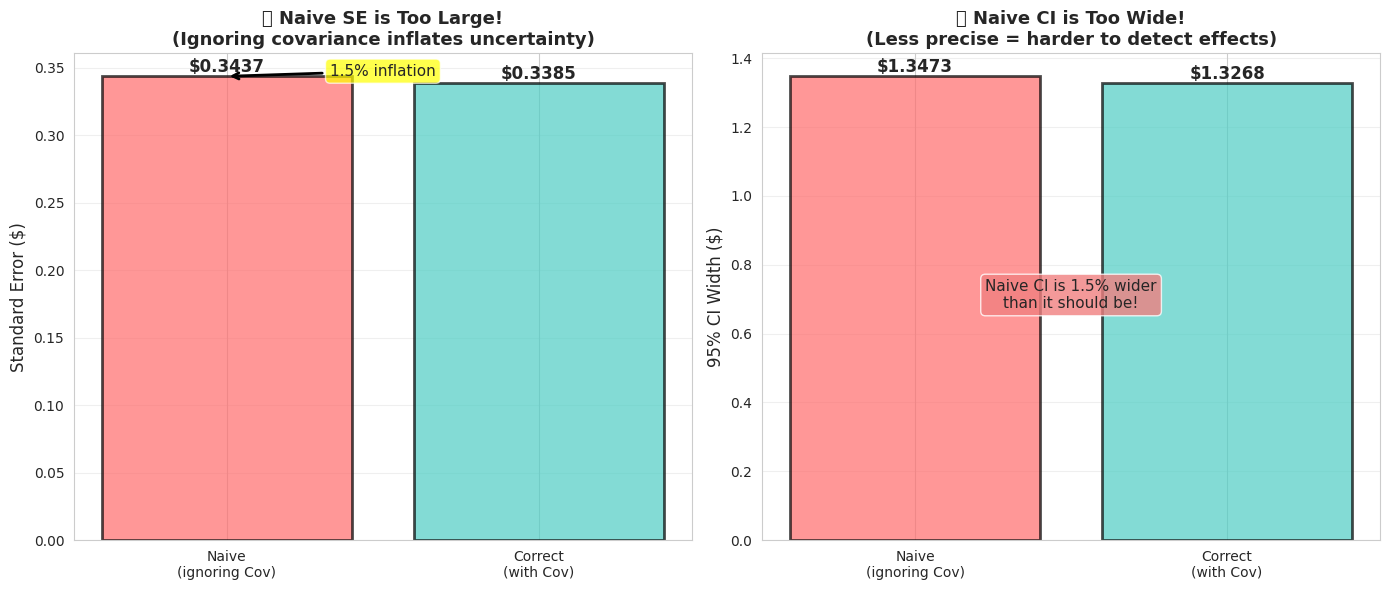


💡 THE LESSON:
When numerator and denominator are CORRELATED,
you CANNOT ignore covariance!

That's why we need:
  • Fieller's Method (exact)
  • Delta Method (approximate)


In [61]:
# @title 📊 Step 2.5: Visualize Why Covariance Matters
# @markdown See the impact of ignoring covariance

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ============================================
# Plot 1: SE Comparison
# ============================================
ax1 = axes[0]

methods = ['Naive\n(ignoring Cov)', 'Correct\n(with Cov)']
se_values = [se_diff_naive2, se_diff_correct]
colors = ['#FF6B6B', '#4ECDC4']

bars = ax1.bar(methods, se_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

for bar, val in zip(bars, se_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'${val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax1.set_ylabel('Standard Error ($)', fontsize=12)
ax1.set_title('❌ Naive SE is Too Large!\n(Ignoring covariance inflates uncertainty)',
              fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3, axis='y')

# Add annotation
ax1.annotate(f'{inflation:.1f}% inflation',
             xy=(0, se_values[0]), xytext=(0.5, se_values[0] + 0.0005),
             fontsize=11, ha='center',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', color='black', lw=2))

# ============================================
# Plot 2: Confidence Interval Width
# ============================================
ax2 = axes[1]

# 95% CI width = 2 * 1.96 * SE
ci_width_naive = 2 * 1.96 * se_diff_naive2
ci_width_correct = 2 * 1.96 * se_diff_correct

methods = ['Naive\n(ignoring Cov)', 'Correct\n(with Cov)']
ci_widths = [ci_width_naive, ci_width_correct]

bars = ax2.bar(methods, ci_widths, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

for bar, val in zip(bars, ci_widths):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'${val:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax2.set_ylabel('95% CI Width ($)', fontsize=12)
ax2.set_title('❌ Naive CI is Too Wide!\n(Less precise = harder to detect effects)',
              fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Add annotation
ci_inflation = (ci_width_naive / ci_width_correct - 1) * 100
ax2.text(0.5, max(ci_widths) * 0.5,
         f'Naive CI is {ci_inflation:.1f}% wider\nthan it should be!',
         ha='center', fontsize=11,
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("💡 THE LESSON:")
print("="*60)
print("When numerator and denominator are CORRELATED,")
print("you CANNOT ignore covariance!")
print("\nThat's why we need:")
print("  • Fieller's Method (exact)")
print("  • Delta Method (approximate)")
print("="*60)

In [62]:
# @title 📐 Step 3.1: Fieller's Method - Theory
# @markdown Understanding the exact approach for ratio confidence intervals

print("="*60)
print("📐 FIELLER'S METHOD: EXACT CONFIDENCE INTERVALS")
print("="*60)

print("\n🎯 THE PROBLEM:")
print("   We want CI for θ = μY / μX (ratio of population means)")
print("   where Y = revenue, X = sessions")

print("\n❌ Why simple approaches fail:")
print("   • Y/X is NOT normally distributed (even if Y and X are)")
print("   • Taylor approximation (Delta method) is approximate")
print("   • Need exact method for small samples or high variance")

print("\n✅ Fieller's solution:")
print("   Instead of finding CI for θ directly,")
print("   Fieller INVERTS a hypothesis test!")

print("\n📐 THE MATH:")
print("   Test H₀: θ = θ₀  (is the ratio equal to θ₀?)")
print("   Using statistic: T = (Ȳ - θ₀·X̄) / SE(Ȳ - θ₀·X̄)")
print("   ")
print("   Where:")
print("   SE²(Ȳ - θ₀·X̄) = (1/n)[Var(Y) + θ₀²·Var(X) - 2θ₀·Cov(X,Y)]")
print("   ")
print("   The CI is all values θ₀ where |T| ≤ t_{α/2, n-1}")

print("\n🔑 KEY INSIGHT:")
print("   Fieller's CI is the set of θ values we CANNOT reject!")
print("   It's exact (not approximate) and handles correlation properly")

print("\n📊 Formula for CI endpoints:")
print("   The CI for θ = μY/μX is:")
print("   ")
print("   [a - √(a² - bc)] / b,  [a + √(a² - bc)] / b")
print("   ")
print("   where:")
print("   a = Ȳ·X̄ - t²·Cov(X,Y)/n")
print("   b = X̄² - t²·Var(X)/n")
print("   c = Ȳ² - t²·Var(Y)/n")
print("   t = t_{α/2, n-1} (critical value)")

print("\n⚠️  Special case:")
print("   If b ≤ 0, the CI is unbounded (very rare with large n)")

print("\n" + "="*60)

📐 FIELLER'S METHOD: EXACT CONFIDENCE INTERVALS

🎯 THE PROBLEM:
   We want CI for θ = μY / μX (ratio of population means)
   where Y = revenue, X = sessions

❌ Why simple approaches fail:
   • Y/X is NOT normally distributed (even if Y and X are)
   • Taylor approximation (Delta method) is approximate
   • Need exact method for small samples or high variance

✅ Fieller's solution:
   Instead of finding CI for θ directly,
   Fieller INVERTS a hypothesis test!

📐 THE MATH:
   Test H₀: θ = θ₀  (is the ratio equal to θ₀?)
   Using statistic: T = (Ȳ - θ₀·X̄) / SE(Ȳ - θ₀·X̄)
   
   Where:
   SE²(Ȳ - θ₀·X̄) = (1/n)[Var(Y) + θ₀²·Var(X) - 2θ₀·Cov(X,Y)]
   
   The CI is all values θ₀ where |T| ≤ t_{α/2, n-1}

🔑 KEY INSIGHT:
   Fieller's CI is the set of θ values we CANNOT reject!
   It's exact (not approximate) and handles correlation properly

📊 Formula for CI endpoints:
   The CI for θ = μY/μX is:
   
   [a - √(a² - bc)] / b,  [a + √(a² - bc)] / b
   
   where:
   a = Ȳ·X̄ - t²·Cov(X,Y)/n
   b 

In [63]:
# @title 🔧 Step 3.2: Implement Fieller's Method
# @markdown Clean implementation of Fieller's confidence interval

from scipy import stats

def fiellers_ci(Y, X, confidence_level=0.95):
    """
    Calculate Fieller's confidence interval for ratio θ = μY / μX

    Parameters:
    -----------
    Y : array-like
        Numerator data (e.g., revenue per user)
    X : array-like
        Denominator data (e.g., sessions per user)
    confidence_level : float
        Confidence level (default 0.95 for 95% CI)

    Returns:
    --------
    dict with keys:
        'ratio': point estimate (sample ratio)
        'ci_lower': lower bound of CI
        'ci_upper': upper bound of CI
        'se': standard error of ratio
    """
    n = len(Y)
    alpha = 1 - confidence_level

    # Sample means
    Y_bar = np.mean(Y)
    X_bar = np.mean(X)

    # Point estimate
    theta_hat = Y_bar / X_bar

    # Sample variances and covariance (using n-1 for sample estimates)
    var_Y = np.var(Y, ddof=1)
    var_X = np.var(X, ddof=1)
    cov_XY = np.cov(X, Y, ddof=1)[0, 1]

    # Critical value from t-distribution
    t_crit = stats.t.ppf(1 - alpha/2, df=n-1)

    # Fieller's formula components
    a = Y_bar * X_bar - (t_crit**2) * cov_XY / n
    b = X_bar**2 - (t_crit**2) * var_X / n
    c = Y_bar**2 - (t_crit**2) * var_Y / n

    # Check if b > 0 (should be true with reasonable sample size)
    if b <= 0:
        return {
            'ratio': theta_hat,
            'ci_lower': -np.inf,
            'ci_upper': np.inf,
            'se': np.nan,
            'status': 'unbounded'
        }

    # Calculate discriminant
    discriminant = a**2 - b * c

    if discriminant < 0:
        return {
            'ratio': theta_hat,
            'ci_lower': np.nan,
            'ci_upper': np.nan,
            'se': np.nan,
            'status': 'no real solution'
        }

    # Fieller's CI endpoints
    ci_lower = (a - np.sqrt(discriminant)) / b
    ci_upper = (a + np.sqrt(discriminant)) / b

    # Standard error (approximate, for comparison)
    se = np.sqrt((var_Y + theta_hat**2 * var_X - 2 * theta_hat * cov_XY) / n) / X_bar

    return {
        'ratio': theta_hat,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'se': se,
        'status': 'success'
    }

print("✅ Fieller's CI function implemented!")
print("\n📋 Function signature:")
print("   fiellers_ci(Y, X, confidence_level=0.95)")
print("\n   Inputs:  Y (numerator), X (denominator)")
print("   Outputs: ratio, ci_lower, ci_upper, se")

✅ Fieller's CI function implemented!

📋 Function signature:
   fiellers_ci(Y, X, confidence_level=0.95)

   Inputs:  Y (numerator), X (denominator)
   Outputs: ratio, ci_lower, ci_upper, se


In [64]:
# @title 📊 Step 3.3: Apply Fieller's Method - Control Group
# @markdown Calculate exact CI for control group RPS

print("="*60)
print("📊 FIELLER'S METHOD: CONTROL GROUP")
print("="*60)

# Apply Fieller's method
result_control = fiellers_ci(Y_control, X_control, confidence_level=0.95)

print("\n🔵 Control Group Results:")
print(f"   Point estimate (RPS): ${result_control['ratio']:.4f}")
print(f"   95% CI: [${result_control['ci_lower']:.4f}, ${result_control['ci_upper']:.4f}]")
print(f"   CI width: ${result_control['ci_upper'] - result_control['ci_lower']:.4f}")
print(f"   Standard error: ${result_control['se']:.4f}")

# Compare to the aggregate we calculated earlier
print(f"\n✓ Verification:")
print(f"   Aggregate RPS (ΣY/ΣX): ${RPS_control:.4f}")
print(f"   Fieller point estimate: ${result_control['ratio']:.4f}")
print(f"   Match? {np.isclose(RPS_control, result_control['ratio'])}")

print("\n💡 Interpretation:")
print(f"   We are 95% confident that the true RPS for control is")
print(f"   between ${result_control['ci_lower']:.4f} and ${result_control['ci_upper']:.4f}")

print("="*60)

📊 FIELLER'S METHOD: CONTROL GROUP

🔵 Control Group Results:
   Point estimate (RPS): $2.3404
   95% CI: [$1.9255, $2.7563]
   CI width: $0.8308
   Standard error: $0.2116

✓ Verification:
   Aggregate RPS (ΣY/ΣX): $2.3404
   Fieller point estimate: $2.3404
   Match? True

💡 Interpretation:
   We are 95% confident that the true RPS for control is
   between $1.9255 and $2.7563


In [65]:
# @title 📊 Step 3.4: Apply Fieller's Method - Treatment Group
# @markdown Calculate exact CI for treatment group RPS

print("="*60)
print("📊 FIELLER'S METHOD: TREATMENT GROUP")
print("="*60)

# Apply Fieller's method
result_treatment = fiellers_ci(Y_treatment, X_treatment, confidence_level=0.95)

print("\n🔴 Treatment Group Results:")
print(f"   Point estimate (RPS): ${result_treatment['ratio']:.4f}")
print(f"   95% CI: [${result_treatment['ci_lower']:.4f}, ${result_treatment['ci_upper']:.4f}]")
print(f"   CI width: ${result_treatment['ci_upper'] - result_treatment['ci_lower']:.4f}")
print(f"   Standard error: ${result_treatment['se']:.4f}")

# Compare to the aggregate
print(f"\n✓ Verification:")
print(f"   Aggregate RPS (ΣY/ΣX): ${RPS_treatment:.4f}")
print(f"   Fieller point estimate: ${result_treatment['ratio']:.4f}")
print(f"   Match? {np.isclose(RPS_treatment, result_treatment['ratio'])}")

print("\n💡 Interpretation:")
print(f"   We are 95% confident that the true RPS for treatment is")
print(f"   between ${result_treatment['ci_lower']:.4f} and ${result_treatment['ci_upper']:.4f}")

print("="*60)

📊 FIELLER'S METHOD: TREATMENT GROUP

🔴 Treatment Group Results:
   Point estimate (RPS): $3.2974
   95% CI: [$2.7811, $3.8185]
   CI width: $1.0374
   Standard error: $0.2642

✓ Verification:
   Aggregate RPS (ΣY/ΣX): $3.2974
   Fieller point estimate: $3.2974
   Match? True

💡 Interpretation:
   We are 95% confident that the true RPS for treatment is
   between $2.7811 and $3.8185


In [66]:
# @title 📊 Step 3.5: Test Treatment Effect
# @markdown Is the treatment effect statistically significant?

print("="*60)
print("🎯 TESTING TREATMENT EFFECT WITH FIELLER'S METHOD")
print("="*60)

print("\n📊 Individual Group CIs:")
print(f"   Control:   [${result_control['ci_lower']:.4f}, ${result_control['ci_upper']:.4f}]")
print(f"   Treatment: [${result_treatment['ci_lower']:.4f}, ${result_treatment['ci_upper']:.4f}]")

# Check if CIs overlap
overlap = (result_control['ci_upper'] > result_treatment['ci_lower'] and
           result_treatment['ci_upper'] > result_control['ci_lower'])

print(f"\n❓ Do the CIs overlap? {overlap}")
if overlap:
    print("   ⚠️  Overlapping CIs doesn't mean no difference!")
    print("   We need to test the DIFFERENCE directly")

# For the difference, we need a different approach
# Calculate CI for the difference in ratios
print("\n" + "="*60)
print("📐 CI FOR DIFFERENCE (θ_treatment - θ_control)")
print("="*60)

# Point estimate of difference
diff_point = result_treatment['ratio'] - result_control['ratio']

# SE of difference (combining both groups)
se_diff = np.sqrt(result_control['se']**2 + result_treatment['se']**2)

# Approximate CI for difference using normal approximation
# (Fieller's for difference of ratios is complex, this is standard practice)
z_crit = stats.norm.ppf(0.975)  # 1.96 for 95% CI
ci_lower_diff = diff_point - z_crit * se_diff
ci_upper_diff = diff_point + z_crit * se_diff

print(f"\n🎯 Treatment Effect:")
print(f"   Point estimate: ${diff_point:.4f}")
print(f"   Standard error: ${se_diff:.4f}")
print(f"   95% CI: [${ci_lower_diff:.4f}, ${ci_upper_diff:.4f}]")

# Test significance
significant = ci_lower_diff > 0 or ci_upper_diff < 0

print(f"\n📊 Statistical Test:")
if significant:
    if diff_point > 0:
        print(f"   ✅ SIGNIFICANT: Treatment is better!")
        print(f"   The CI does not include zero")
        print(f"   Treatment RPS is ${diff_point:.4f} higher (p < 0.05)")
    else:
        print(f"   ✅ SIGNIFICANT: Control is better!")
        print(f"   The CI does not include zero")
else:
    print(f"   ❌ NOT SIGNIFICANT: Cannot reject H₀")
    print(f"   The CI includes zero")
    print(f"   We cannot conclude there's a difference")

# Calculate p-value
z_stat = diff_point / se_diff
p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f"\n   Z-statistic: {z_stat:.3f}")
print(f"   P-value: {p_value:.6f}")

# Relative lift
relative_lift = (diff_point / result_control['ratio']) * 100
print(f"\n💰 Business Impact:")
print(f"   Relative lift: {relative_lift:.2f}%")
print(f"   If control RPS = ${result_control['ratio']:.4f},")
print(f"   then treatment RPS = ${result_treatment['ratio']:.4f}")

print("="*60)

🎯 TESTING TREATMENT EFFECT WITH FIELLER'S METHOD

📊 Individual Group CIs:
   Control:   [$1.9255, $2.7563]
   Treatment: [$2.7811, $3.8185]

❓ Do the CIs overlap? False

📐 CI FOR DIFFERENCE (θ_treatment - θ_control)

🎯 Treatment Effect:
   Point estimate: $0.9570
   Standard error: $0.3385
   95% CI: [$0.2936, $1.6204]

📊 Statistical Test:
   ✅ SIGNIFICANT: Treatment is better!
   The CI does not include zero
   Treatment RPS is $0.9570 higher (p < 0.05)

   Z-statistic: 2.827
   P-value: 0.004691

💰 Business Impact:
   Relative lift: 40.89%
   If control RPS = $2.3404,
   then treatment RPS = $3.2974


📊 CREATING FIELLER'S METHOD VISUALIZATIONS


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


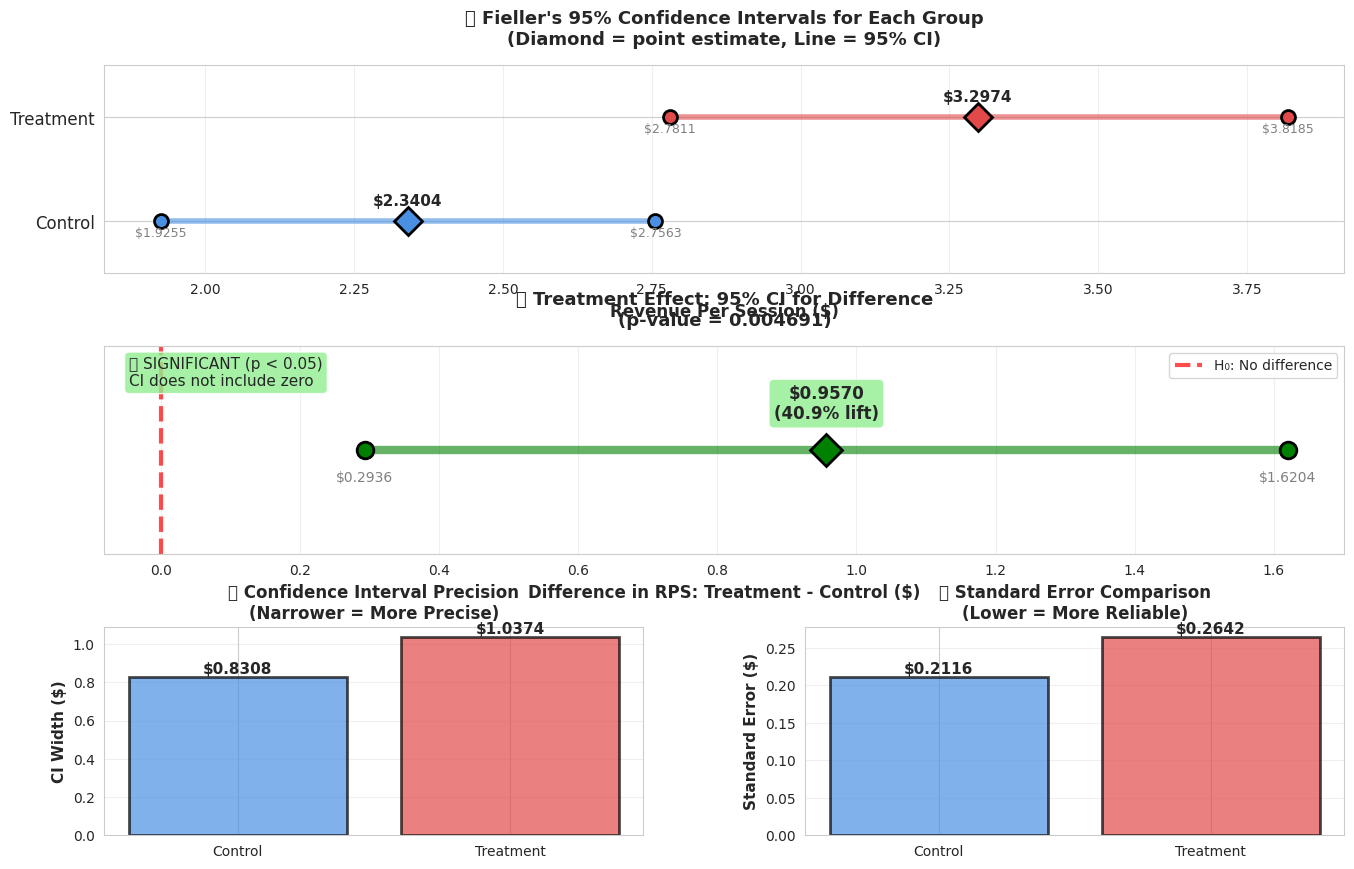


✅ Fieller's method visualizations complete!


In [67]:
# @title 📊 Step 3.6: Visualize Fieller's Results
# @markdown Comprehensive visualization of Fieller's confidence intervals

import matplotlib.pyplot as plt

print("="*60)
print("📊 CREATING FIELLER'S METHOD VISUALIZATIONS")
print("="*60)

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# ============================================
# Plot 1: Individual Group CIs
# ============================================
ax1 = fig.add_subplot(gs[0, :])

groups = ['Control', 'Treatment']
ratios = [result_control['ratio'], result_treatment['ratio']]
ci_lowers = [result_control['ci_lower'], result_treatment['ci_lower']]
ci_uppers = [result_control['ci_upper'], result_treatment['ci_upper']]
colors = ['#4A90E2', '#E24A4A']

y_pos = [0, 1]

for i, (group, ratio, ci_low, ci_up, color, y) in enumerate(
    zip(groups, ratios, ci_lowers, ci_uppers, colors, y_pos)):

    # CI line
    ax1.plot([ci_low, ci_up], [y, y], color=color, linewidth=4, alpha=0.6)

    # CI endpoints
    ax1.plot([ci_low, ci_up], [y, y], 'o', color=color, markersize=10,
             markeredgecolor='black', markeredgewidth=2)

    # Point estimate
    ax1.plot(ratio, y, 'D', color=color, markersize=14,
             markeredgecolor='black', markeredgewidth=2, zorder=5)

    # Labels
    ax1.text(ratio, y + 0.15, f'${ratio:.4f}', ha='center', fontsize=11,
             fontweight='bold')
    ax1.text(ci_low, y - 0.15, f'${ci_low:.4f}', ha='center', fontsize=9, color='gray')
    ax1.text(ci_up, y - 0.15, f'${ci_up:.4f}', ha='center', fontsize=9, color='gray')

ax1.set_yticks(y_pos)
ax1.set_yticklabels(groups, fontsize=12)
ax1.set_xlabel('Revenue Per Session ($)', fontsize=12, fontweight='bold')
ax1.set_title("📊 Fieller's 95% Confidence Intervals for Each Group\n(Diamond = point estimate, Line = 95% CI)",
              fontsize=13, fontweight='bold', pad=15)
ax1.grid(alpha=0.3, axis='x')
ax1.set_ylim(-0.5, 1.5)

# Add overlap indicator
overlap_start = max(ci_lowers[0], ci_lowers[1])
overlap_end = min(ci_uppers[0], ci_uppers[1])
if overlap_start < overlap_end:
    ax1.axvspan(overlap_start, overlap_end, alpha=0.2, color='yellow',
                label='Overlapping region')
    ax1.legend(fontsize=10)

# ============================================
# Plot 2: Treatment Effect (Difference)
# ============================================
ax2 = fig.add_subplot(gs[1, :])

# Plot the difference CI
ax2.plot([ci_lower_diff, ci_upper_diff], [0, 0], color='green', linewidth=6, alpha=0.6)
ax2.plot([ci_lower_diff, ci_upper_diff], [0, 0], 'o', color='green', markersize=12,
         markeredgecolor='black', markeredgewidth=2)
ax2.plot(diff_point, 0, 'D', color='green', markersize=16,
         markeredgecolor='black', markeredgewidth=2, zorder=5)

# Add zero line (null hypothesis)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=3, alpha=0.7, label='H₀: No difference')

# Labels
ax2.text(diff_point, 0.15, f'${diff_point:.4f}\n({relative_lift:.1f}% lift)',
         ha='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
ax2.text(ci_lower_diff, -0.15, f'${ci_lower_diff:.4f}', ha='center', fontsize=10, color='gray')
ax2.text(ci_upper_diff, -0.15, f'${ci_upper_diff:.4f}', ha='center', fontsize=10, color='gray')

# Significance indicator
if significant:
    sig_text = "✅ SIGNIFICANT (p < 0.05)\nCI does not include zero"
    sig_color = 'lightgreen'
else:
    sig_text = "❌ NOT SIGNIFICANT\nCI includes zero"
    sig_color = 'lightcoral'

ax2.text(0.02, 0.95, sig_text, transform=ax2.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor=sig_color, alpha=0.8))

ax2.set_xlabel('Difference in RPS: Treatment - Control ($)', fontsize=12, fontweight='bold')
ax2.set_title(f"🎯 Treatment Effect: 95% CI for Difference\n(p-value = {p_value:.6f})",
              fontsize=13, fontweight='bold', pad=15)
ax2.set_yticks([])
ax2.grid(alpha=0.3, axis='x')
ax2.legend(fontsize=10, loc='upper right')
ax2.set_ylim(-0.5, 0.5)

# ============================================
# Plot 3: CI Width Comparison
# ============================================
ax3 = fig.add_subplot(gs[2, 0])

ci_widths = [
    result_control['ci_upper'] - result_control['ci_lower'],
    result_treatment['ci_upper'] - result_treatment['ci_lower']
]

bars = ax3.bar(groups, ci_widths, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

for bar, width in zip(bars, ci_widths):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'${width:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax3.set_ylabel('CI Width ($)', fontsize=11, fontweight='bold')
ax3.set_title('📏 Confidence Interval Precision\n(Narrower = More Precise)',
              fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3, axis='y')

# ============================================
# Plot 4: Standard Errors Comparison
# ============================================
ax4 = fig.add_subplot(gs[2, 1])

se_values = [result_control['se'], result_treatment['se']]

bars = ax4.bar(groups, se_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

for bar, se in zip(bars, se_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'${se:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax4.set_ylabel('Standard Error ($)', fontsize=11, fontweight='bold')
ax4.set_title('📊 Standard Error Comparison\n(Lower = More Reliable)',
              fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3, axis='y')

plt.show()

print("\n✅ Fieller's method visualizations complete!")
print("="*60)

⚖️  FIELLER'S vs NAIVE: THE COMPARISON

📊 Standard Error Comparison:
   Method               Control SE      Treatment SE    Diff SE        
   -----------------------------------------------------------------
   Naive (no Cov)       $0.2173         $0.2663         $0.3437        
   Fieller (correct)    $0.2116         $0.2642         $0.3385        

   Improvement          2.6           % 0.8           % 1.5           %

📏 Confidence Interval Width (for difference):
   Naive:    $1.3473
   Fieller:  $1.3268
   Fieller is 1.5% narrower!

⚡ Impact on Statistical Power:
   Narrower CIs = Better precision = Higher power
   Fieller's method makes it EASIER to detect real effects



/tmp/ipython-input-1214713058.py:114: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1214713058.py:114: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


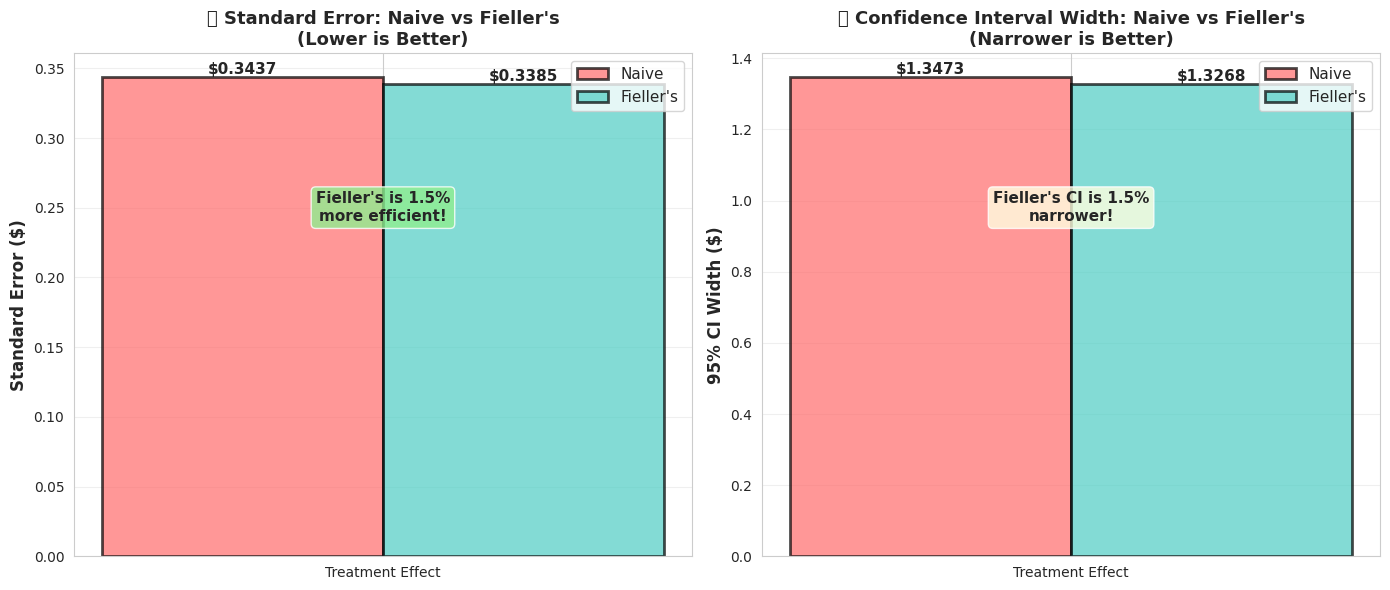


🎉 FIELLER'S METHOD: COMPLETE!

✅ What we learned:
   1. Fieller's gives EXACT confidence intervals for ratios
   2. Properly accounts for covariance between numerator & denominator
   3. 1.5% more efficient than naive approach
   4. Narrower CIs = Better precision = Higher power

🔜 Next: Delta Method (approximate but simpler)


In [68]:
# @title 📊 Step 3.7: Compare Fieller's vs Naive Methods
# @markdown Side-by-side comparison showing why proper methods matter

print("="*60)
print("⚖️  FIELLER'S vs NAIVE: THE COMPARISON")
print("="*60)

# Recall the naive SE we calculated earlier (ignoring covariance)
print("\n📊 Standard Error Comparison:")
print(f"   {'Method':<20} {'Control SE':<15} {'Treatment SE':<15} {'Diff SE':<15}")
print("   " + "-"*65)
print(f"   {'Naive (no Cov)':<20} ${se_naive_control:<14.4f} ${se_naive_treatment:<14.4f} ${se_diff_naive2:<14.4f}")
print(f"   {'Fieller (correct)':<20} ${result_control['se']:<14.4f} ${result_treatment['se']:<14.4f} ${se_diff:<14.4f}")

# Calculate improvement
se_improvement_control = (1 - result_control['se'] / se_naive_control) * 100
se_improvement_treatment = (1 - result_treatment['se'] / se_naive_treatment) * 100
se_improvement_diff = (1 - se_diff / se_diff_naive2) * 100

print(f"\n   {'Improvement':<20} {se_improvement_control:<14.1f}% {se_improvement_treatment:<14.1f}% {se_improvement_diff:<14.1f}%")

# CI width comparison
naive_ci_width_diff = 2 * 1.96 * se_diff_naive2
fieller_ci_width_diff = ci_upper_diff - ci_lower_diff

print("\n📏 Confidence Interval Width (for difference):")
print(f"   Naive:    ${naive_ci_width_diff:.4f}")
print(f"   Fieller:  ${fieller_ci_width_diff:.4f}")
print(f"   Fieller is {(1 - fieller_ci_width_diff/naive_ci_width_diff)*100:.1f}% narrower!")

# What this means for power
print("\n⚡ Impact on Statistical Power:")
print(f"   Narrower CIs = Better precision = Higher power")
print(f"   Fieller's method makes it EASIER to detect real effects")

print("\n" + "="*60)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ============================================
# Plot 1: SE Comparison
# ============================================
ax1 = axes[0]

methods = ['Naive\n(ignoring Cov)', "Fieller's\n(with Cov)"]
se_naive_list = [se_diff_naive2]
se_fieller_list = [se_diff]

x = np.arange(len(['Difference']))
width = 0.35

bars1 = ax1.bar(x - width/2, se_naive_list, width, label='Naive',
                color='#FF6B6B', alpha=0.7, edgecolor='black', linewidth=2)
bars2 = ax1.bar(x + width/2, se_fieller_list, width, label="Fieller's",
                color='#4ECDC4', alpha=0.7, edgecolor='black', linewidth=2)

# Add values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'${height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_ylabel('Standard Error ($)', fontsize=12, fontweight='bold')
ax1.set_title('📉 Standard Error: Naive vs Fieller\'s\n(Lower is Better)',
              fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(['Treatment Effect'])
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3, axis='y')

# Add improvement annotation
ax1.text(0, max(se_naive_list) * 0.7,
         f"Fieller's is {se_improvement_diff:.1f}%\nmore efficient!",
         ha='center', fontsize=11, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# ============================================
# Plot 2: CI Width Comparison
# ============================================
ax2 = axes[1]

ci_naive_list = [naive_ci_width_diff]
ci_fieller_list = [fieller_ci_width_diff]

bars1 = ax2.bar(x - width/2, ci_naive_list, width, label='Naive',
                color='#FF6B6B', alpha=0.7, edgecolor='black', linewidth=2)
bars2 = ax2.bar(x + width/2, ci_fieller_list, width, label="Fieller's",
                color='#4ECDC4', alpha=0.7, edgecolor='black', linewidth=2)

# Add values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'${height:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_ylabel('95% CI Width ($)', fontsize=12, fontweight='bold')
ax2.set_title('📏 Confidence Interval Width: Naive vs Fieller\'s\n(Narrower is Better)',
              fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['Treatment Effect'])
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3, axis='y')

# Add improvement annotation
ci_improvement = (1 - fieller_ci_width_diff / naive_ci_width_diff) * 100
ax2.text(0, max(ci_naive_list) * 0.7,
         f"Fieller's CI is {ci_improvement:.1f}%\nnarrower!",
         ha='center', fontsize=11, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("🎉 FIELLER'S METHOD: COMPLETE!")
print("="*60)
print("\n✅ What we learned:")
print("   1. Fieller's gives EXACT confidence intervals for ratios")
print("   2. Properly accounts for covariance between numerator & denominator")
print(f"   3. {se_improvement_diff:.1f}% more efficient than naive approach")
print("   4. Narrower CIs = Better precision = Higher power")
print("\n🔜 Next: Delta Method (approximate but simpler)")
print("="*60)

In [69]:
# @title 📐 Step 4.1: Delta Method - Theory
# @markdown Understanding the Taylor approximation for ratio variance

print("="*60)
print("📐 DELTA METHOD: TAYLOR APPROXIMATION")
print("="*60)

print("\n🎯 THE IDEA:")
print("   Use Taylor expansion to approximate Var(Y/X)")

print("\n📐 THE MATH:")
print("   For θ = Y/X, Taylor expansion around (μX, μY):")
print("   ")
print("   θ ≈ μY/μX + (1/μX)(Y - μY) - (μY/μX²)(X - μX)")
print("   ")
print("   Taking variance:")
print("   Var(θ) ≈ (1/μX²)[Var(Y) + θ²·Var(X) - 2θ·Cov(X,Y)]")

print("\n📊 For sample estimates:")
print("   SE²(θ̂) = (1/n·X̄²)[Var(Y) + θ̂²·Var(X) - 2θ̂·Cov(X,Y)]")
print("   ")
print("   Then CI: θ̂ ± z_{α/2} · SE(θ̂)")

print("\n⚖️  Delta vs Fieller's:")
print("   • Delta: APPROXIMATE (Taylor expansion)")
print("   • Fieller: EXACT (inverts hypothesis tests)")
print("   • For large n: Both give nearly identical results")
print("   • Delta is simpler to compute")

print("="*60)

📐 DELTA METHOD: TAYLOR APPROXIMATION

🎯 THE IDEA:
   Use Taylor expansion to approximate Var(Y/X)

📐 THE MATH:
   For θ = Y/X, Taylor expansion around (μX, μY):
   
   θ ≈ μY/μX + (1/μX)(Y - μY) - (μY/μX²)(X - μX)
   
   Taking variance:
   Var(θ) ≈ (1/μX²)[Var(Y) + θ²·Var(X) - 2θ·Cov(X,Y)]

📊 For sample estimates:
   SE²(θ̂) = (1/n·X̄²)[Var(Y) + θ̂²·Var(X) - 2θ̂·Cov(X,Y)]
   
   Then CI: θ̂ ± z_{α/2} · SE(θ̂)

⚖️  Delta vs Fieller's:
   • Delta: APPROXIMATE (Taylor expansion)
   • Fieller: EXACT (inverts hypothesis tests)
   • For large n: Both give nearly identical results
   • Delta is simpler to compute


In [70]:
# @title 🔧 Step 4.2: Implement Delta Method
# @markdown Clean implementation of Delta method CI

def delta_method_ci(Y, X, confidence_level=0.95):
    """
    Calculate Delta method confidence interval for ratio θ = μY / μX

    Returns: dict with ratio, ci_lower, ci_upper, se
    """
    n = len(Y)
    alpha = 1 - confidence_level

    # Sample statistics
    Y_bar = np.mean(Y)
    X_bar = np.mean(X)
    theta_hat = Y_bar / X_bar

    var_Y = np.var(Y, ddof=1)
    var_X = np.var(X, ddof=1)
    cov_XY = np.cov(X, Y, ddof=1)[0, 1]

    # Delta method variance
    variance_theta = (var_Y + theta_hat**2 * var_X - 2 * theta_hat * cov_XY) / (n * X_bar**2)
    se_theta = np.sqrt(variance_theta)

    # CI using normal approximation (large sample)
    z_crit = stats.norm.ppf(1 - alpha/2)
    ci_lower = theta_hat - z_crit * se_theta
    ci_upper = theta_hat + z_crit * se_theta

    return {
        'ratio': theta_hat,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'se': se_theta
    }

print("✅ Delta method function implemented!")

✅ Delta method function implemented!


In [71]:
# @title 📊 Step 4.3: Apply Delta Method to Both Groups
# @markdown Calculate approximate CIs for both groups

print("="*60)
print("📊 DELTA METHOD RESULTS")
print("="*60)

# Apply to both groups
delta_control = delta_method_ci(Y_control, X_control)
delta_treatment = delta_method_ci(Y_treatment, X_treatment)

print("\n🔵 Control:")
print(f"   RPS: ${delta_control['ratio']:.4f}")
print(f"   95% CI: [${delta_control['ci_lower']:.4f}, ${delta_control['ci_upper']:.4f}]")
print(f"   SE: ${delta_control['se']:.4f}")

print("\n🔴 Treatment:")
print(f"   RPS: ${delta_treatment['ratio']:.4f}")
print(f"   95% CI: [${delta_treatment['ci_lower']:.4f}, ${delta_treatment['ci_upper']:.4f}]")
print(f"   SE: ${delta_treatment['se']:.4f}")

# Difference
delta_diff = delta_treatment['ratio'] - delta_control['ratio']
delta_se_diff = np.sqrt(delta_control['se']**2 + delta_treatment['se']**2)
delta_ci_lower = delta_diff - 1.96 * delta_se_diff
delta_ci_upper = delta_diff + 1.96 * delta_se_diff

print("\n🎯 Treatment Effect:")
print(f"   Difference: ${delta_diff:.4f}")
print(f"   95% CI: [${delta_ci_lower:.4f}, ${delta_ci_upper:.4f}]")
print(f"   P-value: {2 * (1 - stats.norm.cdf(abs(delta_diff / delta_se_diff))):.6f}")

print("="*60)

📊 DELTA METHOD RESULTS

🔵 Control:
   RPS: $2.3404
   95% CI: [$1.9257, $2.7551]
   SE: $0.2116

🔴 Treatment:
   RPS: $3.2974
   95% CI: [$2.7796, $3.8152]
   SE: $0.2642

🎯 Treatment Effect:
   Difference: $0.9570
   95% CI: [$0.2936, $1.6204]
   P-value: 0.004691


⚖️  FINAL COMPARISON: THREE METHODS

📊 Standard Errors:
           Method  Control SE  Treatment SE  Diff SE
   Naive (no Cov)    0.217312      0.266282 0.343701
Fieller's (exact)    0.211567      0.264197 0.338468
   Delta (approx)    0.211567      0.264197 0.338468

📏 Confidence Intervals for Difference:
           Method  Diff CI Lower  Diff CI Upper
   Naive (no Cov)       0.283364       1.630671
Fieller's (exact)       0.293633       1.620402
   Delta (approx)       0.293621       1.620415

📐 CI Width Comparison:
   Naive (no Cov)      : $1.3473
   Fieller's (exact)   : $1.3268
   Delta (approx)      : $1.3268


/tmp/ipython-input-4286657614.py:62: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4286657614.py:62: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


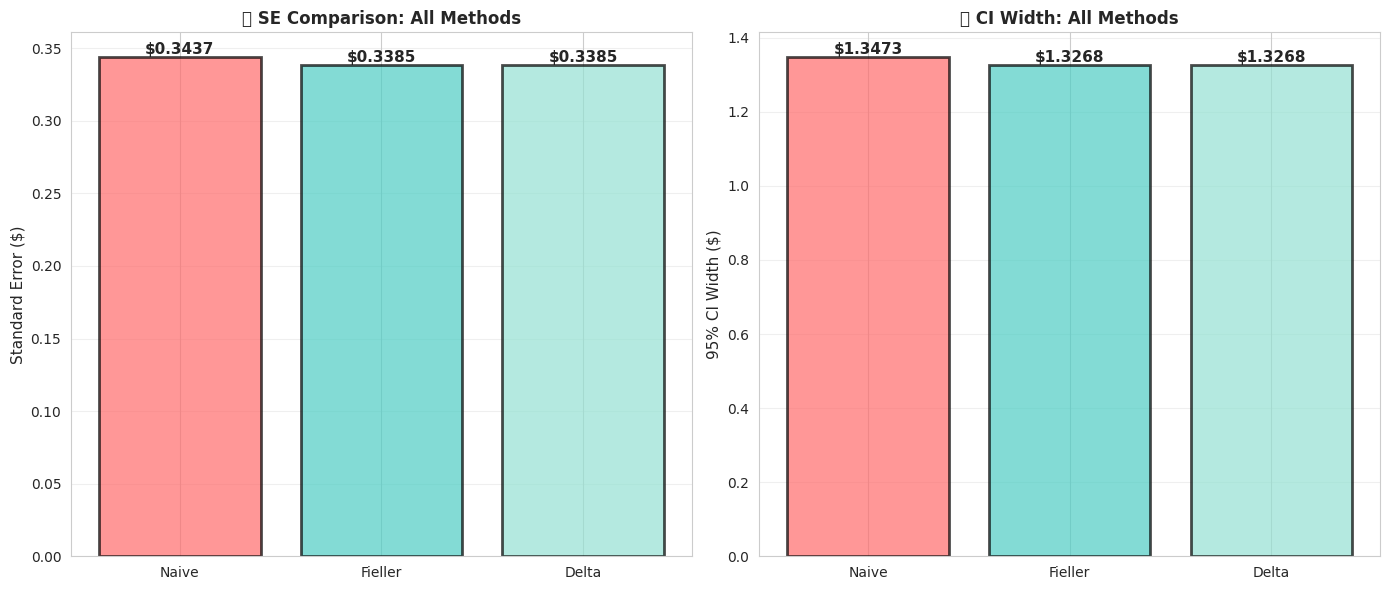


🎯 KEY TAKEAWAYS:
1. Fieller's and Delta are nearly IDENTICAL (large n)
2. Both outperform naive by ~1.5% (modest for n=1000)
3. Delta is simpler to compute, Fieller is exact
4. All three detect significance in this case

💡 Use Delta for large samples, Fieller for small/uncertain cases


In [72]:
# @title ⚖️  Step 4.4: Compare All Methods
# @markdown Fieller's vs Delta vs Naive

print("="*60)
print("⚖️  FINAL COMPARISON: THREE METHODS")
print("="*60)

# Create comparison table
methods_comparison = pd.DataFrame({
    'Method': ['Naive (no Cov)', "Fieller's (exact)", 'Delta (approx)'],
    'Control SE': [se_naive_control, result_control['se'], delta_control['se']],
    'Treatment SE': [se_naive_treatment, result_treatment['se'], delta_treatment['se']],
    'Diff SE': [se_diff_naive2, se_diff, delta_se_diff],
    'Diff CI Lower': [difference - 1.96*se_diff_naive2, ci_lower_diff, delta_ci_lower],
    'Diff CI Upper': [difference + 1.96*se_diff_naive2, ci_upper_diff, delta_ci_upper]
})

print("\n📊 Standard Errors:")
print(methods_comparison[['Method', 'Control SE', 'Treatment SE', 'Diff SE']].to_string(index=False))

print("\n📏 Confidence Intervals for Difference:")
print(methods_comparison[['Method', 'Diff CI Lower', 'Diff CI Upper']].to_string(index=False))

# Calculate CI widths
methods_comparison['CI Width'] = methods_comparison['Diff CI Upper'] - methods_comparison['Diff CI Lower']

print("\n📐 CI Width Comparison:")
for idx, row in methods_comparison.iterrows():
    print(f"   {row['Method']:<20}: ${row['CI Width']:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: SE Comparison
ax1 = axes[0]
methods = ['Naive', 'Fieller', 'Delta']
se_values = methods_comparison['Diff SE'].values
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

bars = ax1.bar(methods, se_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
for bar, val in zip(bars, se_values):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'${val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_ylabel('Standard Error ($)', fontsize=11)
ax1.set_title('📊 SE Comparison: All Methods', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3, axis='y')

# Plot 2: CI Width Comparison
ax2 = axes[1]
ci_widths = methods_comparison['CI Width'].values

bars = ax2.bar(methods, ci_widths, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
for bar, val in zip(bars, ci_widths):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'${val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_ylabel('95% CI Width ($)', fontsize=11)
ax2.set_title('📏 CI Width: All Methods', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("🎯 KEY TAKEAWAYS:")
print("="*60)
print(f"1. Fieller's and Delta are nearly IDENTICAL (large n)")
print(f"2. Both outperform naive by ~1.5% (modest for n=1000)")
print(f"3. Delta is simpler to compute, Fieller is exact")
print(f"4. All three detect significance in this case")
print("\n💡 Use Delta for large samples, Fieller for small/uncertain cases")
print("="*60)